# load measurements and prepare for the compression & LFI

Notebook divided into 2 parts. First part loads into memory the measurements - both in sims (Dirac / cosmogrid) and Data. Second part performs the compression

In [1]:
import sys
import numpy as np
import pickle
import matplotlib.pyplot as plt
import copy
import glob
import os 
import astropy.io.fits as pf

def save_obj(name, obj):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, protocol=2)
        f.close()

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        mute =  pickle.load(f)
        f.close()
    return mute

            
        

def covariance_jck(TOTAL_PHI,jk_r,type_cov):
  if type_cov=='jackknife':
      fact=(jk_r-1.)/(jk_r)

  elif type_cov=='bootstrap':
      fact=1./(jk_r)
  #  Covariance estimation

  average=np.zeros(TOTAL_PHI.shape[0])
  cov_jck=np.zeros((TOTAL_PHI.shape[0],TOTAL_PHI.shape[0]))
  err_jck=np.zeros(TOTAL_PHI.shape[0])


  for kk in range(jk_r):
    average+=TOTAL_PHI[:,kk]
  average=average/(jk_r)

 # print average
  for ii in range(TOTAL_PHI.shape[0]):
     for jj in range(ii+1):
          for kk in range(jk_r):
            cov_jck[jj,ii]+=TOTAL_PHI[ii,kk]*TOTAL_PHI[jj,kk]

          cov_jck[jj,ii]=(-average[ii]*average[jj]*jk_r+cov_jck[jj,ii])*fact
          cov_jck[ii,jj]=cov_jck[jj,ii]

  for ii in range(TOTAL_PHI.shape[0]):
   err_jck[ii]=np.sqrt(cov_jck[ii,ii])
 # print err_jck

  #compute correlation
  corr=np.zeros((TOTAL_PHI.shape[0],TOTAL_PHI.shape[0]))
  for i in range(TOTAL_PHI.shape[0]):
      for j in range(TOTAL_PHI.shape[0]):
        corr[i,j]=cov_jck[i,j]/(np.sqrt(cov_jck[i,i]*cov_jck[j,j]))

  average=average*fact
  return {'cov' : cov_jck,
          'err' : err_jck,
          'corr':corr,
          'mean':average}


def get_labels(mina,maxa,filters = [0,1,2,3,4,5], bins = ['0_0', '0_1', '0_2', '0_3', '1_0', '1_1', '1_2', '1_3', '2_0', '2_1', '2_2', '2_3', '3_0', '3_1', '3_2', '3_3']):
    data_labels = []

    # define dv indexes:
  
    dv_index = []
    bins_index = []
    for f_ in filters:
        dv_index.append([str(int(f_))+'_'+str(int(f_))+'_'+'S00'])

    for f_ in filters:
        dv_index.append([str(int(f_))+'_'+str(int(f_))+'_'+'S11'])

    for f_ in filters:
        dv_index.append([str(int(f_))+'_'+str(int(f_))+'_'+'S01'])

    for f_ in filters:
        for f_1 in filters:
            if f_<f_1:
                dv_index.append([str(int(f_))+'_'+str(int(f_1))+'_'+'C01_dl0'])
                dv_index.append([str(int(f_))+'_'+str(int(f_1))+'_'+'C01_dl1'])

    for f_ in filters:
        for f_1 in filters:
            if f_<f_1:
                dv_index.append([str(int(f_))+'_'+str(int(f_1))+'_'+'Cphase'])



    for b, binx in enumerate(bins):
        for dd in dv_index[mina:maxa]:
            data_labels.append('bin_'+binx+'_'+dd[0])
            bins_index.append('bin_'+binx+'_')
    
    return data_labels,bins_index


# read peaks -------------

def read_peaks(m_):
    count = 0
    for t in m_.peaks['k_sm_kE'].keys():
        for sc in m_.peaks['k_sm_kE'][t].keys():
            if count == 0:
                dv = (m_.peaks['k_sm_kE'][t][sc]-m_.peaks['kn_sm_kE'][t][sc]) 
                tomo    = t*np.ones(len(m_.peaks['k_sm_kE'][t][sc]))
                filters = sc*np.ones(len(m_.peaks['k_sm_kE'][t][sc]))
                scales = m_.peaks['k_sm_kE'][t][sc]
                
            else:
                dv = np.hstack([dv,(m_.peaks['k_sm_kE'][t][sc]-m_.peaks['kn_sm_kE'][t][sc]) ])
                tomo_    = t*np.ones(len(m_.peaks['k_sm_kE'][t][sc]))
                filters_ = sc*np.ones(len(m_.peaks['k_sm_kE'][t][sc]))

                tomo = np.hstack([tomo,tomo_])
                filters = np.hstack([filters,filters_])

                scales = np.hstack([scales,m_.peaks['k_sm_kE'][t][sc]])
            count +=1
    return dv,filters,scales,tomo



f = glob.glob('/global/cfs/cdirs/des/mgatti/LFI_CDFs/chains/*')
results = dict()
for f_ in f:
    k = f_.split('compression_')[1].split('.pkl')[0]
    try:
        results[k]
    except:
        results[k] = dict()
        
        
    
    m = load_obj(f_.split('.pkl')[0])
    if '2_params_' in f_:
        results[k]['S8'] = m[:,:,1].std()
        results[k]['om'] = m[:,:,0].std()
        results[k]['om_c'] = m[:,:,0]
        results[k]['S8_c'] = m[:,:,1]
    elif '2_s8w_params' in f_:
        results[k]['S8_w'] = m[:,:,0].std()
        results[k]['w'] = m[:,:,1].std()
        results[k]['S8_w_c'] = m[:,:,0]
        results[k]['w_c'] = m[:,:,1]
    else:
        results[k]['S8_A'] = m[:,:,0].std()
        results[k]['A'] = m[:,:,1].std()
        results[k]['S8_A_c'] = m[:,:,0]
        results[k]['A_c'] = m[:,:,1]
    #print (k,'{0:2.3f} {1:2.3f}'.format(m[:,:,1].std(),m[:,:,0].std()))
    
f = glob.glob('/global/cfs/cdirs/des/mgatti/LFI/chains/*')
results0 = dict()
for f_ in f:
    k = f_.split('compression_')[1].split('.pkl')[0]
    try:
        results0[k]
    except:
        results0[k] = dict()
        
        
    
    m = load_obj(f_.split('.pkl')[0])
    if '2_params_' in f_:
        results0[k]['S8'] = m[:,:,1].std()
        results0[k]['om'] = m[:,:,0].std()
        results0[k]['om_c'] = m[:,:,0]
        results0[k]['S8_c'] = m[:,:,1]
    elif '2_s8w_params' in f_:
        results0[k]['S8_w'] = m[:,:,0].std()
        results0[k]['w'] = m[:,:,1].std()
        results0[k]['S8_w_c'] = m[:,:,0]
        results0[k]['w_c'] = m[:,:,1]
    else:
        results0[k]['S8_A'] = m[:,:,0].std()
        results0[k]['A'] = m[:,:,1].std()
        results0[k]['S8_A_c'] = m[:,:,0]
        results0[k]['A_c'] = m[:,:,1]
        
        
        
        
f = glob.glob('/global/cfs/cdirs/des/mgatti/LFI_0/chains/*')
results1 = dict()
for f_ in f:
    k = f_.split('compression_')[1].split('.pkl')[0]
    try:
        results1[k]
    except:
        results1[k] = dict()
        
        
    
    m = load_obj(f_.split('.pkl')[0])
    if '2_params_' in f_:
        results1[k]['S8'] = m[:,:,1].std()
        results1[k]['om'] = m[:,:,0].std()
        results1[k]['om_c'] = m[:,:,0]
        results1[k]['S8_c'] = m[:,:,1]
    elif '2_s8w_params' in f_:
        results1[k]['S8_w'] = m[:,:,0].std()
        results1[k]['w'] = m[:,:,1].std()
        results1[k]['S8_w_c'] = m[:,:,0]
        results1[k]['w_c'] = m[:,:,1]
    else:
        results1[k]['S8_A'] = m[:,:,0].std()
        results1[k]['A'] = m[:,:,1].std()
        results1[k]['S8_A_c'] = m[:,:,0]
        results1[k]['A_c'] = m[:,:,1]
        
   


def do_scale_cut(chain1,chain2,p1='$\Omega_m$',p2='$S_8$'):
    from getdist.paramnames import escapeLatex, makeList, mergeRenames

    su = [chain1,chain2]
    # labels and limits for the plot ************
    param1 = p1
    #param1 = 'ns'
    param2 = p2
    xlims = [0.15,0.40]
    #xlims = [0.85,1.05]
    ylims = [0.65,1.]
    xlab= p1

    ylab = p2


    # truth values (irrelevant almost) ******
    param1_truth = 0.28
    #param1_truth = 0.97
    param2_truth = 0.79

    # qui disegna un ellisse di 0.3 sigma ******
    uncc = 0.3
    unc1 = 0.3

    # plotting script

    Samples = su
    roots = makeList(Samples)

    g = plots.getSinglePlotter(ratio = 5./3., width_inch= 5. )




    dx = np.absolute(xlims[1] - xlims[0])
    dy = np.absolute(ylims[1] - ylims[0])

    param2_cont, param1_cont = get_max_2dpost(g, roots[1],param1=param1, param2=param2)
    param2_base, param1_base = get_max_2dpost(g, roots[0],param1=param1, param2=param2)

    param_pair = g.get_param_array(roots[0], None or [param1, param2])
    density = g.sample_analyser.get_density_grid(roots[0], param_pair[0], param_pair[1],
                                                                conts=g.settings.num_plot_contours,
                                                                likes=g.settings.shade_meanlikes)

    g = plots.getSinglePlotter()
    density_cont = g.sample_analyser.get_density_grid(roots[1], param_pair[0], param_pair[1],
                                                                conts=g.settings.num_plot_contours,
                                                                likes=g.settings.shade_meanlikes)


    # Get the 2D distance in terms of sigma. In case you get some weird getdist error, change the starting guess value (here 0.01)
    res_truth_base = min_find(0.005,g, density, param1_truth, param2_truth)
    #print(res_truth_base)
    res_cont_base = min_find(0.005,g, density_cont, param1_base, param2_base)
    print(res_cont_base)
    res_base_cont = min_find(0.005,g, density, param1_cont, param2_cont)
    print(res_base_cont)
    res_truth_cont = min_find(0.005,g, density_cont, param1_truth, param2_truth)
    #print(res_truth_cont)

    line = get_contour_line(uncc,g, density)
    line_cont = get_contour_line(uncc,g, density_cont)


    line1 = get_contour_line(unc1,g, density)
    line_cont1 = get_contour_line(unc1,g, density_cont)
    '''
    fig, ax = pl.subplots(1, figsize=(3,2.5))
    #ax.axvline(param1_truth,ls='--',alpha=0.3,color='k')
    #ax.axhline(param2_truth,ls='--',alpha=0.3,color='k')

    #ax.set_xlim(xlims[0],xlims[1])
    #ax.set_ylim(ylims[0],ylims[1])
    ax.plot([param1_cont],[param2_cont], linestyle='', marker='s', color=c_23,label='baseline')
    ax.plot([param1_base],[param2_base], linestyle='', marker='o', color=c_2,label='contaminated')
    ax.plot(line[0][:,0],line[0][:,1], linestyle='--', marker='',lw=1, color=c_2,label=r'${0:2.1f} \sigma$ contaminated'.format(uncc))
    #ax.plot(line_cont[0][:,0],line_cont[0][:,1], linestyle='--', marker='',lw=1, color=c_23,label=r'${0:2.1f} \sigma$ baseline'.format(uncc))
    ax.set_xlabel(xlab)

    ax.set_ylabel(ylab)
    #ax.annotate('', xy=(param1_truth, param2_truth), xytext=(param1_base, param2_base),
    #            arrowprops={'arrowstyle': '->'}, va='center')
    #ax.annotate('', xy=(param1_truth, param2_truth), xytext=(param1_cont, param2_cont),
    #            arrowprops={'arrowstyle': '->'}, va='center')
    ax.annotate('', xy=(param1_base, param2_base), xytext=(param1_cont, param2_cont),
                arrowprops={'arrowstyle': '->'}, va='center')
    # ax.annotate('', xy=(param1_cont, param2_cont), xytext=(param1_base, param2_base),
    #             arrowprops={'arrowstyle': '->'}, va='center')


    #ax.legend(fontsize=13,loc='lower right')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
    ax.tick_params(axis='both', which='major')
    ax.tick_params(axis='both', which='minor')

    fracx, fracy, angle = get_frac_angle(np.array([param1_cont, param2_cont]),np.array([param1_base,param2_base]),xlims, ylims)
    #plt.savefig('/global/homes/m/mgatti/Mass_Mapping/Moments_analysis/mcmc/figures/contaminated_nss8_final.pdf',bbox_inches='tight')
    #
    '''
    return  res_cont_base,res_base_cont


import matplotlib
from getdist import plots, MCSamples
import numpy as np
import matplotlib.pyplot as pl
import matplotlib
import pdb
import scipy.optimize as op
import scipy.special as spsp
from getdist.paramnames import escapeLatex, makeList, mergeRenames
#matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True
import getdist


def get_nsample(filename):
    with open(filename,"r") as fi:
        for ln in fi:
            if ln.startswith("#nsample="):
                nsamples = int(ln[9:])
    return nsamples

def get_evidence(filename):
    with open(filename,"r") as fi:
        for ln in fi:
            if ln.startswith("#log_z="):
                logz = float(ln[7:])
    return logz


def get_param_names(filename):
    with open(filename,"r") as fi:
        param_names = np.array((fi.readline()[1:].split()))
    return param_names


def get_S8(data, names, Omega_m_name = 'cosmological_parameters--omega_m', sigma_8_name = 'COSMOLOGICAL_PARAMETERS--SIGMA_8', alpha=0.5):
    output_names = []
    ind_data = []
    for ii in range(len(names)):
        if (names[ii] in [Omega_m_name]):
            Omega_m_ind = ii
        if (names[ii] in [sigma_8_name]):
            sig8_ind = ii
    sigma_8 = data[:,sig8_ind]
    omega_m = data[:,Omega_m_ind]
    s8 = sigma_8 * (omega_m/0.3)**alpha
    return s8

def get_Obh2(data, names, Omega_b_name = 'cosmological_parameters--omega_b', h_name = 'cosmological_parameters--h0'):
    output_names = []
    ind_data = []
    for ii in range(len(names)):
        if (names[ii] in [Omega_b_name]):
            Omega_b_ind = ii
        if (names[ii] in [h_name]):
            h_ind = ii
    h0 = data[:,h_ind]
    omega_b = data[:,Omega_b_ind]
    return omega_b * (h0**2)

def get_Omh3(data, names, Omega_m_name = 'cosmological_parameters--omega_m', h_name = 'cosmological_parameters--h0'):
    output_names = []
    ind_data = []
    for ii in range(len(names)):
        if (names[ii] in [Omega_m_name]):
            Omega_m_ind = ii
        if (names[ii] in [h_name]):
            h_ind = ii
    h0 = data[:,h_ind]
    omega_m = data[:,Omega_m_ind]
    return omega_m * (h0**3)

def get_max_2dpost(g, root, param1='cosmological_parameters--omega_m', param2='cosmological_parameters--s8',param_pair = None):
    param_pair = g.get_param_array(root, param_pair or [param1, param2])
    
    density = g.sample_analyser.get_density_grid(root, param_pair[0], param_pair[1],
                                                                conts=g.settings.num_plot_contours,
                                                                likes=g.settings.shade_meanlikes)
    xyind = np.where(density.P == np.amax(density.P))
    return density.y[xyind[0][0]],density.x[xyind[1][0]]
    
def get_contour_line(sigma_contour,g, density):

    contours = spsp.erf(sigma_contour/np.sqrt(2))
    density.contours = density.getContourLevels([contours])
    contour_levels = density.contours
    fig1, ax1 = pl.subplots(1)
    cs = pl.contour(density.x, density.y, density.P, sorted(contour_levels))
    lines = []
    for line in cs.collections[0].get_paths():
        lines.append(line.vertices)
    pl.close()
    return lines

def get_dmin(line, xref, yref):
    linex = line[0][:,0]
    liney = line[0][:,1]
    d_all = np.sqrt((linex - xref)**2 + (liney - yref)**2)
    dmin = np.amin(d_all)
    return dmin

def lefthand(sigma_contour, g, density, xref, yref): 
    line = get_contour_line(sigma_contour,g, density)
    result = get_dmin(line, xref, yref)  
    return result

lefthand = np.vectorize(lefthand)
   
def diff(sigma_contour, g, density, xref, yref):
    result = lefthand(sigma_contour, g, density, xref, yref)
    return result

def root_find(init_x,g, density, xref, yref): 
    nll = lambda *args: diff(*args)
    args = (g, density, xref, yref)
    result = op.root(nll,np.array([init_x]),args=args,options={'maxfev':50})
    return result

def min_find(init_x,g, density, xref, yref): 
    nll = lambda *args: diff(*args)
    args = (g, density, xref, yref)
    result = op.fmin(nll,np.array([init_x]),args=args)
    return result#-0.003
 
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))   

def get_frac_angle(start_coord, end_coord,xlims, ylims):
    xmean12 = (0.5*(start_coord[0] + end_coord[0]))
    ymean12 = (0.5*(start_coord[1] + end_coord[1]))
    dx = xlims[1] - xlims[0]
    dy = ylims[1] - ylims[0]
    dxp = xmean12 - end_coord[0]
    dyp = ymean12 - end_coord[1]
    angle_deg = 180.+ np.arctan2((end_coord[1]-start_coord[1])/dy,( end_coord[0]-start_coord[0])/dx)*(180./np.pi)
    return xmean12-dxp/2, ymean12+dyp/3, angle_deg

def replace_fancy(names, fancy_dic):
    output_names = []
    ind_data = []
    for ii in range(len(names)):
        if (names[ii] in fancy_dic):
            output_names.append(fancy_dic[names[ii]])
            ind_data.append(ii)
    return np.array(output_names), np.array(ind_data)


# dict_keysb = ['2_3tomocross_kEkE_Baryons_20', '3tomocross_kEkE_Baryons_24', '2tomocross_kEkE_Baryons_24', '2_3tomocross_kEkE_Baryons_20', '3tomocross_kEkE_Baryons_20', '2tomocross_kEkE_Baryons_20', '2_3tomocross_kEkE_Baryons_28', '3tomocross_kEkE_Baryons_28', '2tomocross_kEkE_Baryons_28'])
#dict_keys =  ['2_3tomocross_kEkE_Theory_20', '3tomocross_kEkE_Theory_24', '2tomocross_kEkE_Theory_24', '2_3tomocross_kEkE_Theory_20', '3tomocross_kEkE_Theory_20', '2tomocross_kEkE_Theory_20', '2_3tomocross_kEkE_Theory_28', '3tomocross_kEkE_Theory_28', '2tomocross_kEkE_Theory_28'])
#dict_keysb = ['2tomocross_kEkE_Baryons_20', '3tomocross_kEkE_Baryons_24', '2tomocross_kEkE_Baryons_24', '2_3tomocross_kEkE_Baryons_20', '3tomocross_kEkE_Baryons_20', '2tomocross_kEkE_Baryons_20', '2_3tomocross_kEkE_Baryons_28', '3tomocross_kEkE_Baryons_28', '2tomocross_kEkE_Baryons_28'])
#dict_keys =  ['2tomocross_kEkE_Theory_20', '3tomocross_kEkE_Theory_24', '2tomocross_kEkE_Theory_24', '2_3tomocross_kEkE_Theory_20', '3tomocross_kEkE_Theory_20', '2tomocross_kEkE_Theory_20', '2_3tomocross_kEkE_Theory_28', '3tomocross_kEkE_Theory_28', '2tomocross_kEkE_Theory_28'])
#

        
        



# some settings

In [2]:
do_peaks = True

# Load Dirac sims

In [3]:
base = '/global/cfs/cdirs/des/mgatti/Dirac/LFI/'

moments_reg = dict()
files = glob.glob(base+'/moments/*')
params_ = []

                  
dv2 = []
dv3 = []
dv2b_n = []
dv3d = []
dv3dn = []
dv3nn = []
dv2b = []
dv2_n = []
dv3b = []
dvS = []
dvSb  = []
sr_dv = []
dv2_S2 = []
dv2_S2n = []

cl_dv_all = []
dhaya = []
count = 0
cl_dv_all = []
cl_dv_all_n = []

cl_dv_all1 = []
cl_dv_all_n1 = []
f = 0
special_ = []
noise_ = []
rot_ =[]
folder_ =[]

dv_peaks = []


import frogress
for i in frogress.bar(range(len(files[:]))):
    
    
    file = files[i]
    

    name_ = file.split(base+'/moments/')[1]
    lu = name_.split('nside')[0]     
    runname = name_.split('_')[3]
    folder_run = name_.split('_')[2]
    cutout = int(name_.split('rel')[2].split('.')[0])
    noise = (name_.split('rel')[1].split('_')[0])
    lab = folder_run.split('runs')[1]+noise



    rot_.append(cutout)

    name_2 = base+'/ST/'+name_
    name_P = base+'/WPH/'+name_
    name_cl = base+'/cl/'+name_
    name_peaks = base+'/peaks_th/'+name_

    if do_peaks:
        m = load_obj(name_peaks.split('.pkl')[0])
        dv_peaks_,filters_peaks,scales_peaks,tomo_peaks = read_peaks(m[0])
        

    # Params -----------------------
    
    xx = file.split('/')[-1].split('.npy')[0]
    fold = xx.split('runs')[1].split('_')[0]
    run_= int(xx.split('run')[2].split('_')[0])

    xu = xx.split('_rel')[0]
    rel = xx.split('_rel')[1].split('.pkl')[0]
    m = np.load('/global/cfs/cdirs/des/mgatti/Dirac_mocks/'+xu+'.npy',allow_pickle=True).item()


    f = open(('/global/homes/m/mgatti/Mass_Mapping/peaks/params_run_1_Niall_{0}.txt'.format(fold)),'r')
    om_ = []
    s8_ = []
    w = []
    ob = []
    h = []
    ns= []

    for i,f_ in enumerate(f):

        if i>0:
            om_.append(float(f_.split(',')[0]))
            s8_.append(float(f_.split(',')[1]))
            w.append(float(f_.split(',')[2]))
            ob.append(float(f_.split(',')[3]))
            h.append(float(f_.split(',')[4]))
            ns.append(float(f_.split(',')[5]))
    om_ = om_[run_-1]
    s8_ = s8_[run_-1]
    w = w[run_-1]
    ob_ = ob[run_-1]
    h_ = h[run_-1]
    ns_ = ns[run_-1]
    params = [om_, s8_*np.sqrt(om_/0.3), w, h_,ob_,ns_,m[int(rel)]['config']['A_IA'],m[int(rel)]['config']['eta_IA'],m[int(rel)]['config']['m_sources'][0],m[int(rel)]['config']['m_sources'][1],m[int(rel)]['config']['m_sources'][2],m[int(rel)]['config']['m_sources'][3],m[int(rel)]['config']['rel'][3]]
    params_.append(params)                                              

    noise_.append(int(noise))
    if do_peaks:
        dv_peaks.append(dv_peaks_)
        
    #cl_dv_all.append(cl_dv)
    #cl_dv_all_n.append(cl_dvn)

    folder_.append(lu)

    count += 1

params_ = np.array(params_)
import glob
count

dd = dict()

dd['params'] = params_
    
if do_peaks:
    dd['peaks'] = dv_peaks
    dd['scales_peaks'] = scales_peaks
    dd['filters_peaks'] = filters_peaks
    dd['tomo_peaks'] = tomo_peaks
    
    
dd['noise_'] = np.array(noise_)
dd['folder_'] = np.array(folder_)
    
np.save('/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv/Dirac_dvs',dd)


[##########] | Progress: 0 / 0 | Time: 0.0s | ETA: --

NameError: name 'scales_peaks' is not defined

A few comments:
 - we will take the average noise and subtract it off second moments, S00, PHW Gaussian, ST1 and ST2
 - we won't do it for third moments or S01

In [4]:
[_,_,_,_,masks, _] = load_obj('/global/cfs/cdirs/des/mgatti/Dirac/_24km_new')
dv_final = dict()
data_labels,bins_index = get_labels(0,70,filters = [0,1,2,3,4,5])
# SECOND MOMENTS **********
dd = np.load('/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv/Dirac_dvs.npy',allow_pickle=True).item()

if do_peaks:

    dv_final['peaks'] = np.array(dd['peaks'])
    mask_peaks_Dirac = ~(np.mean( np.array(dd['peaks']),axis=0)==0)
    dv_final['peaks'] = dv_final['peaks'][:,mask_peaks_Dirac]
    

params_  = np.array(dd['params'] )

for key in dv_final.keys():
    dv_final[key] =  dv_final[key][np.where((np.abs(params_[:,7])<5) &((params_[:,2])>-1.01)  )]
    
    
params = params_[np.where((np.abs(params_[:,7])<5) &((params_[:,2])>-1.01) )]
noise_masked = np.array(dd['noise_'])[np.where((np.abs(params_[:,7])<5) &((params_[:,2])>-1.01)  )]



params = params[:,:]
params[:,2] = params[:,2] + 1.2
params[:,6] = (params[:,6] +3)/6.
params[:,7] = (params[:,7] +5)/10.


params[:,5]  = params[:,5]   - 0.5
params[:,8]  = np.array(params[:,8] )  - 1.
params[:,9]  = np.array(params[:,9] )  - 1.
params[:,10] = np.array(params[:,10])  - 1.
params[:,11] = np.array(params[:,11])  - 1.

# compute mean redshifts
mu = pf.open('//global/cfs/cdirs//des/www/y3_chains/data_vectors/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate_6000HR.fits')
def compute_mean(uu):
    u1 = np.trapz(uu.data['Z_MID']*uu.data['BIN1'],uu.data['Z_MID'])/np.trapz(uu.data['BIN1'],uu.data['Z_MID'])
    u2 = np.trapz(uu.data['Z_MID']*uu.data['BIN2'],uu.data['Z_MID'])/np.trapz(uu.data['BIN2'],uu.data['Z_MID'])
    u3 = np.trapz(uu.data['Z_MID']*uu.data['BIN3'],uu.data['Z_MID'])/np.trapz(uu.data['BIN3'],uu.data['Z_MID'])
    u4 = np.trapz(uu.data['Z_MID']*uu.data['BIN4'],uu.data['Z_MID'])/np.trapz(uu.data['BIN4'],uu.data['Z_MID'])
    return u1,u2,u3,u4
r1,r2,r3,r4 = compute_mean(mu[6])
p1 = []
p2 = []
p3 = []
p4 = []
for i in params[:,-1]:
    f1,f2,f3,f4 = compute_mean(mu[8+int(i)])
    p1.append(f1-r1)
    p2.append(f2-r2)
    p3.append(f3-r3)
    p4.append(f4-r4)
params[:,-1] = np.array(p1)    
params = np.vstack([params.T,np.array(p2)]).T
params = np.vstack([params.T,np.array(p3)]).T
params = np.vstack([params.T,np.array(p4)]).T

# Load data

In [5]:
# read data -----


        
data_all_dict = dict()



[params_,[dv1,dv1b,special_],sr1,data_labels,masks, cl_data,[dv2,dv3,dv2b,dv3b,dvS,dvSb,special_1],dv2_S2,labels_S2] = np.load('/global/cfs/cdirs/des/mgatti/Dirac/_datavector_Cc1_.npy',allow_pickle=True)
[_,_,_,_,masks, _] = np.load('/global/cfs/cdirs/des/mgatti/Dirac/_24km_new.npy',allow_pickle=True)

masks['S00'] = [(('S00' in np.array(data_labels)[i])) for i in range(len(data_labels))]
masks['S01'] = [(('S01' in np.array(data_labels)[i]) )for i in range(len(data_labels))]
masks['C01'] = [(('C01' in np.array(data_labels)[i]) or ('S01' in data_labels[i])  )for i in range(len(data_labels))]


data_all_dict['data'] = dict()

cl = np.load('/global/cfs/cdirs/des/mgatti/pywph_results/cl_data_512.npy',allow_pickle=True).item()


for ii,kk in enumerate(cl.keys()):
    if ii == 0:
        mask = (cl[kk][2]>30) & (cl[kk][2]<950)
        cl_dv = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
        cl_dvn = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])


    else:
        u = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
        cl_dv = np.hstack([u,cl_dv])
        u = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])
        cl_dvn = np.hstack([u,cl_dvn])
        
data_all_dict['data']['cl'] = {'dv':cl_dv-cl_dvn}
        
    
    
cl = np.load('/global/cfs/cdirs/des/mgatti/pywph_results/cl_data_512_now.npy',allow_pickle=True).item()

for ii,kk in enumerate(cl.keys()):
    if ii == 0:
        mask = (cl[kk][2]>30) & (cl[kk][2]<950)
        cl_dv = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
        cl_dvn = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])


    else:
        u = np.hstack([(cl[kk][0][0])[mask],(cl[kk][0][3])[mask]])
        cl_dv = np.hstack([u,cl_dv])
        u = np.hstack([(cl[kk][1][0])[mask],(cl[kk][1][3])[mask]])
        cl_dvn = np.hstack([u,cl_dvn])


# *******************************************
mcal_moments = load_obj('/global/cfs/cdirs/des/mgatti/pywph_results/peaks_old_th')
dv_peaks_,filters_peaks,scales_peaks,tomo_peaks = read_peaks(mcal_moments)
data_all_dict['data']['peaks'] = {'dv':np.array(dv_peaks_)[mask_peaks_Dirac]}


# Load Cosmogrid


New cosmogrid maps are in /global/cfs/cdirs/des/mgatti/cosmogrid/baryons_cosmogridfiducial_final1/

New Datavectors are  in /global/cfs/cdirs/des/mgatti/Dirac/LFI_dv_cosmogrid_fiducial/




In [6]:
Call_dict = dict()
Call_dict['data'] = dict()
pp = '/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv_cosmogrid_fiducial/'

f = glob.glob(pp+'/peaks/cosmogrid_peaks*')
count = 0
for f_ in f:
    m = load_obj(f_.split('.pkl')[0])
    dv_peaks_,filters_peaks,scales_peaks,tomo_peaks = read_peaks(m)
    if count == 0:
        Call_dict['data']['peaks'] = {'dv':dv_peaks_}
    else:
         Call_dict['data']['peaks']['dv'] += dv_peaks_
    count +=1      
Call_dict['data']['peaks']['dv'] = Call_dict['data']['peaks']['dv'].astype('float')
Call_dict['data']['peaks']['dv'] /= count
Call_dict['data']['peaks']['dv'] = Call_dict['data']['peaks']['dv'][mask_peaks_Dirac]

In [7]:
Ball_dict = dict()
Ball_dict['data'] = dict()
pp = '/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv_cosmogrid_fiducial/'


f = glob.glob(pp+'/peaks/cosmogrid_b_peaks_*')
count = 0
for f_ in f:
    m = load_obj(f_.split('.pkl')[0])
    dv_peaks_,filters_peaks,scales_peaks,tomo_peaks = read_peaks(m)
    if count == 0:
        Ball_dict['data']['peaks'] = {'dv':dv_peaks_}
    else:
        Ball_dict['data']['peaks']['dv'] += dv_peaks_
    count +=1      
Ball_dict['data']['peaks']['dv'] = Ball_dict['data']['peaks']['dv'].astype('float')
Ball_dict['data']['peaks']['dv'] /= count
Ball_dict['data']['peaks']['dv'] = Ball_dict['data']['peaks']['dv'][mask_peaks_Dirac]

In [8]:
Dall_dict = dict()
Dall_dict['data'] = dict()
pp = '/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv_cosmogrid_fiducial/'

    
f = glob.glob(pp+'/peaks/cosmogrid_peaks*')
f = np.sort(f)
count = 0
for f_ in f:
    m = load_obj(f_.split('.pkl')[0])
    dv_peaks_,filters_peaks,scales_peaks,tomo_peaks = read_peaks(m)
    if count == 0:
        Dall_dict['data']['peaks'] = [dv_peaks_.astype('float')[mask_peaks_Dirac]]
    else:
        Dall_dict['data']['peaks'].append(dv_peaks_.astype('float')[mask_peaks_Dirac])
    count +=1

In [9]:
Dall_dict.keys()

dict_keys(['data'])

In [10]:
Sall_dict = dict()
Sall_dict['data'] = dict()
pp = '/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv_SC/'

'''

f = glob.glob(pp+'/peaks/cosmogrid_b_peaks_*')
count = 0
for f_ in f:
    m = load_obj(f_.split('.pkl')[0])
    dv_peaks_,filters_peaks,scales_peaks,tomo_peaks = read_peaks(m)
    if count == 0:
        Sall_dict['data']['peaks'] = {'dv':dv_peaks_}
    else:
        Sall_dict['data']['peaks']['dv'] += dv_peaks_
    count +=1      
Sall_dict['data']['peaks']['dv'] = Sall_dict['data']['peaks']['dv'].astype('float')
Sall_dict['data']['peaks']['dv'] /= count
Sall_dict['data']['peaks']['dv'] = Sall_dict['data']['peaks']['dv'][mask_peaks_Dirac]
'''

"\n\nf = glob.glob(pp+'/peaks/cosmogrid_b_peaks_*')\ncount = 0\nfor f_ in f:\n    m = load_obj(f_.split('.pkl')[0])\n    dv_peaks_,filters_peaks,scales_peaks,tomo_peaks = read_peaks(m)\n    if count == 0:\n        Sall_dict['data']['peaks'] = {'dv':dv_peaks_}\n    else:\n        Sall_dict['data']['peaks']['dv'] += dv_peaks_\n    count +=1      \nSall_dict['data']['peaks']['dv'] = Sall_dict['data']['peaks']['dv'].astype('float')\nSall_dict['data']['peaks']['dv'] /= count\nSall_dict['data']['peaks']['dv'] = Sall_dict['data']['peaks']['dv'][mask_peaks_Dirac]\n"

In [11]:

Rall_dict = dict()
Rall_dict['data'] = dict()
pp = '/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv_cosmogrid/'
pp1 = '/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv_SC/'

In [17]:
f = glob.glob('/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv_cosmogrid_fiducial/WPH/*')
len(f)

798

# Define masks

In [18]:
# mask for cosmogrid
masks_dv = dict()

meas_2nd = 10*2 #(len(all_dict['data']['2nd_moments']['dv'])/8)
meas_3rd = 64#*2 #(len(all_dict['data']['3rd_moments']['dv'])/8)
scales_moments = [8.2,13.1,21.0,33.6,54.,86.,138,221.]
scales_2nd_mom = np.array(scales_moments*meas_2nd)
scales_3rd_mom = np.array(scales_moments*meas_3rd)
data_labels_pwh,bins_index = get_labels(0,70,filters = [0,1,2,3,4,5])

bins_2 = ['0_0', '0_1', '0_2', '0_3', '1_1', '1_2', '1_3', '2_2', '2_3', '3_3']
bins_3 = np.unique(['0_0_0', '0_0_1', '0_0_2', '0_0_3', '0_1_1', '0_1_2', '0_1_3', '0_2_2', '0_2_3', '0_3_3', '1_1_1', '1_1_2', '1_1_3', '1_2_2', '1_2_3', '1_3_3', '2_2_2', '2_2_3', '2_3_3', '3_3_3', '0_1_0', '0_2_0', '0_2_1', '0_3_0', '0_3_1', '0_3_2', '1_0_0', '1_0_1', '1_0_2', '1_0_3', '1_1_0', '1_2_0', '1_2_1', '1_3_0', '1_3_1', '1_3_2', '2_0_0', '2_0_1', '2_0_2', '2_0_3', '2_1_0', '2_1_1', '2_1_2', '2_1_3', '2_2_0', '2_2_1', '2_3_0', '2_3_1', '2_3_2', '3_0_0', '3_0_1', '3_0_2', '3_0_3', '3_1_0', '3_1_1', '3_1_2', '3_1_3', '3_2_0', '3_2_1', '3_2_2', '3_2_3', '3_3_0', '3_3_1', '3_3_2'])
bins_2_lb = [[u]*len(scales_moments) for u in bins_2]  
bins_3_lb = [[u]*len(scales_moments) for u in bins_3]  

In [19]:
dd['tomo_peaks'] =tomo_peaks
dd['filters_peaks'] = filters_peaks

masks_dv = dict()

meas_2nd = 10*2 #(len(all_dict['data']['2nd_moments']['dv'])/8)
meas_3rd = 64#*2 #(len(all_dict['data']['3rd_moments']['dv'])/8)
scales_moments = [8.2,13.1,21.0,33.6,54.,86.,138,221.]
scales_2nd_mom = np.array(scales_moments*meas_2nd)
scales_3rd_mom = np.array(scales_moments*meas_3rd)
data_labels_pwh,bins_index = get_labels(0,70,filters = [0,1,2,3,4,5])

bins_2 = ['0_0', '0_1', '0_2', '0_3', '1_1', '1_2', '1_3', '2_2', '2_3', '3_3']
bins_3 = np.unique(['0_0_0', '0_0_1', '0_0_2', '0_0_3', '0_1_1', '0_1_2', '0_1_3', '0_2_2', '0_2_3', '0_3_3', '1_1_1', '1_1_2', '1_1_3', '1_2_2', '1_2_3', '1_3_3', '2_2_2', '2_2_3', '2_3_3', '3_3_3', '0_1_0', '0_2_0', '0_2_1', '0_3_0', '0_3_1', '0_3_2', '1_0_0', '1_0_1', '1_0_2', '1_0_3', '1_1_0', '1_2_0', '1_2_1', '1_3_0', '1_3_1', '1_3_2', '2_0_0', '2_0_1', '2_0_2', '2_0_3', '2_1_0', '2_1_1', '2_1_2', '2_1_3', '2_2_0', '2_2_1', '2_3_0', '2_3_1', '2_3_2', '3_0_0', '3_0_1', '3_0_2', '3_0_3', '3_1_0', '3_1_1', '3_1_2', '3_1_3', '3_2_0', '3_2_1', '3_2_2', '3_2_3', '3_3_0', '3_3_1', '3_3_2'])
bins_2_lb = [[u]*len(scales_moments) for u in bins_2]  
bins_3_lb = [[u]*len(scales_moments) for u in bins_3]  


bins = []
for i in range(6):
    for j in range(6):
        for l in range(3):
            if i<=j:
                bins.append('{0}_{1}'.format(i,j,l))

ST2_labels = np.array(bins*10)
ST1_labels = np.array([0,1,2,3,4,5]*10)


# SMALL SCALES  -------------------------------------------------
key = 'everything_nosm'
masks_dv[key] = dict()
masks_dv[key]['mask_peaks'] = np.array([ dd_ != 0 for dd_ in dd['filters_peaks'][mask_peaks_Dirac]])



# SMALL SCALES  -------------------------------------------------
key = 'small_scales'
masks_dv[key] = dict()
masks_dv[key]['mask_peaks'] = np.array([ dd_ != 0 for dd_ in dd['filters_peaks'][mask_peaks_Dirac]]) & np.array([ dd_ != 1 for dd_ in dd['filters_peaks'][mask_peaks_Dirac]])

# LARGE SCALES  -------------------------------------------------
key = 'large_scales'
masks_dv[key] = dict()
masks_dv[key]['mask_peaks'] = ~ masks_dv['small_scales']['mask_peaks']



# everything  -------------------------------------------------
key = 'everything'
masks_dv[key] = dict()
masks_dv[key]['mask_peaks'] =  masks_dv['small_scales']['mask_peaks'] == masks_dv['small_scales']['mask_peaks']

In [20]:
0

0

# save DVs for compression & LFI

In [41]:
folder = '/global/cfs/cdirs/des/shubh/graphs/out/'   
if not os.path.exists(folder):
    os.mkdir(folder)
    
ff = ['everything']#_nosm']
# type_ = 'cosmogrid_B'#,'cosmogrid']
#type_ = 'cosmogrid_B'
type_ = "data"
for key in ff:     
    
    # mask the Dirac sims
    
    Adv_final = copy.deepcopy(dv_final)
    
    if do_peaks:
        Adv_final['peaks'] = dv_final['peaks'][:,masks_dv[key]['mask_peaks']]
        
    # mask the target data vector *************************
    if type_ == 'data':
        Adata_all_dict = copy.deepcopy(data_all_dict)
    elif type_ == 'cosmogrid':
        Adata_all_dict = copy.deepcopy(Call_dict)
    elif type_ == 'cosmogrid_B':
        Adata_all_dict = copy.deepcopy(Ball_dict)   


        
    output_folder  = folder +key+'_data/' 
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
        
    dv_final_t = dict()
    dv_final_v = dict()
    dv_final_a = dict()
    mask_noiserel = noise_masked == 3
    for k in Adv_final.keys():
        
        dv_final_t[k] = Adv_final[k][~mask_noiserel,:]  
        dv_final_v[k] = Adv_final[k][mask_noiserel,:]    
        dv_final_a[k] = Adv_final[k]  
    all_you_need = dict()
    all_you_need['dv_final_t'] = dv_final_t
    all_you_need['dv_final_v'] = dv_final_v
    all_you_need['dv_final_a'] = dv_final_a
    all_you_need['params'] = params
    all_you_need['data'] = Adata_all_dict
    all_you_need['mask_noiserel'] = mask_noiserel
    
    if type_ == 'data':
        np.save(output_folder+'/Aall_you_need',all_you_need)

    elif type_ == 'cosmogrid':
        np.save(output_folder+'/Aall_you_need_cosmogrid',all_you_need)

    elif type_ == 'cosmogrid_B':
        np.save(output_folder+'/Aall_you_need_cosmogrid_B',all_you_need)



In [42]:
all_you_need['dv_final_t'].keys(), all_you_need['dv_final_t']['peaks'].shape

(dict_keys(['peaks']), (8496, 1120))

In [43]:
1

1

# Compression

Generally we want to compress only using the training (3/4) data.

In [44]:
import sys

    
import copy
import matplotlib.pyplot as plt
import getdist
import random
import emcee as mc
from getdist import plots, MCSamples

import scipy.interpolate as interpolate
import time
from scipy.interpolate import UnivariateSpline
import tensorflow as tf

from scipy.integrate import simps
tf.test.is_gpu_available()
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
import sys

import pickle
def save_obj(name, obj):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, protocol=2)
        f.close()

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        mute =  pickle.load(f)
        f.close()
    return mute

import glob
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

c_2=rgb_to_hex((239, 96, 96))
c_3=rgb_to_hex((255, 194, 0)) 
c_23=rgb_to_hex((121, 183, 179)) 
c_4=rgb_to_hex((30, 183, 179)) 
c_cs="black"#rgb_to_hex((161, 13, 79)) 



import pickle
def save_obj(name, obj):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, protocol=2)
        f.close()

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        mute =  pickle.load(f)
        f.close()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam
#
#
def simple_model_2d_3k(input_size, lr=1e-4):
    # create model
    model = Sequential()
    model.add(Dense(2900, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1900, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1000, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))

    # model.add(ReLU())
    model.add(Dense(500, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    model.add(Dense(100, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    model.add(Dense(20, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    # model.add(ReLU())
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(optimizer=Adam(lr=lr), loss='mse')
    return model


def simple_model_2d_2k(input_size, lr=1e-4):
    # create model
    model = Sequential()
    model.add(Dense(1200, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(800, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    # model.add(ReLU())
    model.add(Dense(100, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    model.add(Dense(100, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    # model.add(ReLU())
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(optimizer=Adam(lr=lr), loss='mse')
    return model




from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam
#
#

def simple_model_2d_1k(input_size, lr=1e-4):
    # create model
    model = Sequential()
    model.add(Dense(900, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(800, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    # model.add(ReLU())
    model.add(Dense(100, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    model.add(Dense(100, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    # model.add(ReLU())
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(optimizer=Adam(lr=lr), loss='mse')
    return model



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam
#
#
def simple_model_2d_100(input_size, lr=1e-4):
    # create model
    model = Sequential()
    model.add(Dense(90, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(80, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    # model.add(ReLU())
    model.add(Dense(10, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    model.add(Dense(10, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    # model.add(ReLU())
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(optimizer=Adam(lr=lr), loss='mse')
    return model

def do_compression(key,all_you_need):
        
        dv_final = all_you_need['dv_final_t']
        params = all_you_need['params'][~all_you_need['mask_noiserel']]

        if not os.path.exists(output_folder+'/compression/'+label_run+'_'+key+'.npy'):
                #'''
                sim_data =  np.clip(0.5+0.2 * ( all_you_need['dv_final_t'][key]-np.median( all_you_need['dv_final_t'][key],axis=0)) / np.std( all_you_need['dv_final_t'][key], axis=0) ,-0.5,1.5)
                sim_data_v =  np.clip(0.5+0.2 * ( all_you_need['dv_final_v'][key]-np.median( all_you_need['dv_final_t'][key],axis=0)) / np.std( all_you_need['dv_final_t'][key], axis=0) ,-0.5,1.5)
                sim_data_a =  np.clip(0.5+0.2 * ( all_you_need['dv_final_a'][key]-np.median( all_you_need['dv_final_t'][key],axis=0)) / np.std( all_you_need['dv_final_t'][key], axis=0) ,-0.5,1.5)
                
                len_  = dv_final[key].shape[1]
                if len_ > 2000:
                    regression_power = simple_model_2d_3k(sim_data.shape[1], lr=1e-5)
                elif len_ > 700:
                    regression_power = simple_model_2d_2k(sim_data.shape[1], lr=1e-5)
                elif len_ > 100:
                    regression_power = simple_model_2d_1k(sim_data.shape[1], lr=1e-5)
                else:
                    regression_power = simple_model_2d_100(sim_data.shape[1], lr=1e-5)

                regression_power.summary()
                
                special_ = np.arange(sim_data.shape[0])<1000
                for i in range(8):
                    
                    numerical_noise = np.random.normal(sim_data*0.,2e-3)
                    history_2d_power = regression_power.fit((sim_data+numerical_noise)[~special_],
                               params[~special_,:][:,mm],
                               epochs =10,batch_size = 32, shuffle=True,
                               validation_data = ((sim_data)[special_],
                                                  params[special_,:][:,mm]))


                compressed_data_t  = np.clip(regression_power.predict(sim_data), -1., 1.5)
                compressed_data_v  = np.clip(regression_power.predict(sim_data_v), -1., 1.5)
                compressed_data_a  = np.clip(regression_power.predict(sim_data_a), -1., 1.5)


            
                results = {'sim_params_t': all_you_need['params'][~all_you_need['mask_noiserel']],
                           'sim_params_v': all_you_need['params'][all_you_need['mask_noiserel']],
                           'sim_params_a': all_you_need['params'],
                           'compressed_data_t':compressed_data_t, 'compressed_data_v':compressed_data_v, 
                           'compressed_data_a':compressed_data_a}
                np.save(output_folder+'/compression/'+label_run+'_'+key,results)
                regression_power.save_weights((output_folder+'/compression_models/'+label_run+'_'+key))
                
                #'''

2023-11-13 01:20:17.994697: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 35061 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [46]:
ff = ['everything_nosm']
ff = ['everything']
type_ = 'data'#,'cosmogrid']
# type_ = 'cosmogrid_B'
for key in ff:     
    
    output_folder  = folder +key+'_'+type_+'/' 

   
    all_you_need = np.load(output_folder+'Aall_you_need.npy',allow_pickle=True).item()
        

    label_run_chain = '4p_'
    label_runs = ['Om','S8','w','A']
    mm_ = np.array([True,True,True,False,False,False,True,False,False,False,False,False])

   # label_runs = ['2_params_compression']
    for iii,label_run in enumerate(label_runs):
    


        if label_run == 'h0':
            mm = np.array([False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False])

        if label_run == 'ob':
            mm = np.array([False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False])


        if label_run == 'ns':
            mm = np.array([False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False])
 

        if label_run == 'S8':
            mm = np.array([False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False])


        if label_run == 'Om':
            mm = np.array([True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False])

        if label_run == 'w':
            mm = np.array([False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False])

        if label_run == 'A':
            mm = np.array([False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False])

        if label_run == 'E':
            mm = np.array([False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False])

        if label_run == 'm1':
            mm = np.array([False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False])



        if label_run == 'm2':
            mm = np.array([False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False])

            
        if label_run == 'm3':
            mm = np.array([False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False])

        if label_run == 'm4':
            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False])

         
        if label_run == 'dz1':
            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False])

            
        if label_run == 'dz2':
            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False])
            
        if label_run == 'dz3':
            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False])
      
        if label_run == 'dz4':
            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True])
      

        result_dir = '../../../../../../pscratch/sd/m/mgatti/temp/'
        #result_dir = '../../../../../cscratch/sd/mgatti/temp/'

        try:
            os.mkdir(output_folder+'/compression/')
            
        except:
            pass
        

        try:
            os.mkdir(output_folder+'/compression_models/')
        except:
            pass
                
        
        runstodo = len(all_you_need['dv_final_t'].keys())
        run_count=0
        keys = list(all_you_need['dv_final_t'].keys())
          
        while run_count<runstodo:
            if (run_count)<runstodo:
                print('doing',keys[run_count])
                do_compression(keys[run_count],all_you_need)
            run_count+=1

doing peaks


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1200)              1345200   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1200)              0         
                                                                 
 dense_6 (Dense)             (None, 800)               960800    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 800)               0         
                                                                 
 dense_7 (Dense)             (None, 100)               80100     
                                                                 
 re_lu_2 (ReLU)              (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 100)              

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 1200)              1345200   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 1200)              0         
                                                                 
 dense_11 (Dense)            (None, 800)               960800    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 800)               0         
                                                                 
 dense_12 (Dense)            (None, 100)               80100     
                                                                 
 re_lu_4 (ReLU)              (None, 100)               0         
                                                                 
 dense_13 (Dense)            (None, 100)              

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 1200)              1345200   
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 1200)              0         
                                                                 
 dense_16 (Dense)            (None, 800)               960800    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 800)               0         
                                                                 
 dense_17 (Dense)            (None, 100)               80100     
                                                                 
 re_lu_6 (ReLU)              (None, 100)               0         
                                                                 
 dense_18 (Dense)            (None, 100)              

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 1200)              1345200   
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 1200)              0         
                                                                 
 dense_21 (Dense)            (None, 800)               960800    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 800)               0         
                                                                 
 dense_22 (Dense)            (None, 100)               80100     
                                                                 
 re_lu_8 (ReLU)              (None, 100)               0         
                                                                 
 dense_23 (Dense)            (None, 100)              

In [47]:
1

1

# compressing data vector

In [53]:
ff = ['everything']
#type_ = 'cosmogrid_B'#,'cosmogrid']
#type_ = 'cosmogrid'

folder = '/global/cfs/cdirs/des/shubh/graphs/out/'   


for type_ in ['data']:#,'cosmogrid']:#'cosmogrid_B','cosmogrid']:#,'cosmogrid_B','data']:

    for key in ff:     

        output_folder  = folder +key+'_'+'data'+'/' 

        all_you_need = np.load(output_folder+'Aall_you_need.npy',allow_pickle=True).item()


        if type_ == 'data':
            target = np.load(output_folder+'Aall_you_need.npy',allow_pickle=True).item()

        elif type_ == 'cosmogrid':
            target = np.load(output_folder+'Aall_you_need_cosmogrid.npy',allow_pickle=True).item()

        elif type_ == 'cosmogrid_B':
            target = np.load(output_folder+'Aall_you_need_cosmogrid_B.npy',allow_pickle=True).item()



        # compress ---
        import copy
        path_uu =copy.deepcopy(output_folder)
        #path_uu = '/global/cfs/cdirs/des/mgatti/LFI_new_runs/removed_large/'

        label_runs = ['Om','S8','w','A']

        #dicts_ = {'Dirac':Dall_dict} 
        dv_final = all_you_need['dv_final_t']  
        output_folder = path_uu
        compressed_data = dict()
        #label_runs = ['2_params_compression','2_s8w_params_compression','2_s8A_params_compression']
        #label_runs = ['2_s8w_params_compression'] #,'2_s8w_params_compression','2_s8A_params_compression']



        if 1==1:
            compr_dv = dict()
            #if 1==1:
               # key = 'cl'
            for key in all_you_need['dv_final_t'].keys():
                #if key !='cl':
                    compr_dv[key] = dict()
                    mute = dict()
                    for iii,label_run in enumerate(label_runs):

                        if label_run == 'h0':
                            mm = np.array([False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False])

                        if label_run == 'ob':
                            mm = np.array([False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False])


                        if label_run == 'ns':
                            mm = np.array([False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False])


                        if label_run == 'S8':
                            mm = np.array([False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False])


                        if label_run == 'Om':
                            mm = np.array([True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False])

                        if label_run == 'w':
                            mm = np.array([False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False])

                        if label_run == 'A':
                            mm = np.array([False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False])

                        if label_run == 'E':
                            mm = np.array([False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False])

                        if label_run == 'm1':
                            mm = np.array([False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False])



                        if label_run == 'm2':
                            mm = np.array([False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False])


                        if label_run == 'm3':
                            mm = np.array([False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False])

                        if label_run == 'm4':
                            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False])


                        if label_run == 'dz1':
                            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False])


                        if label_run == 'dz2':
                            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False])

                        if label_run == 'dz3':
                            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False])

                        if label_run == 'dz4':
                            mm = np.array([False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True])



                        len_ = len(target['data']['data'][key]['dv'])
                        dv = copy.deepcopy(target['data']['data'][key]['dv'])
                        dv =  np.clip(0.5+0.2 * (dv-np.median(dv_final[key],axis=0)) / np.std(dv_final[key], axis=0) ,-0.5,1.5)
                        sim_data =  np.clip(0.5+0.2 * (dv_final[key]-np.median(dv_final[key],axis=0)) / np.std(dv_final[key], axis=0) ,-0.5,1.5)

                        if len_ > 2000:
                            regression_power = simple_model_2d_3k(len_, lr=1e-5)
                        elif len_ > 600:
                            regression_power = simple_model_2d_2k(len_, lr=1e-5)
                        elif len_ > 100:
                            regression_power = simple_model_2d_1k(len_, lr=1e-5)
                        else:
                            regression_power = simple_model_2d_100(len_, lr=1e-5)

                        regression_power.summary()
                        regression_power.load_weights((output_folder+'/compression_models/'+label_run+'_'+key))
                        predict = np.clip(regression_power.predict(dv.reshape(1,-1)), -1., 1.5)



                        mute[label_run] = np.load(output_folder+'/compression/'+label_run+'_'+key+'.npy',allow_pickle=True).item()
                        if iii == 0:

                           # compr_dv[key]['sim_params0']  = mute[label_run]['sim_params0'][:,mm] 
                            compr_dv[key]['sim_params_v']  = mute[label_run]['sim_params_v'][:,mm] 
                            compr_dv[key]['compressed_data_v']  = mute[label_run]['compressed_data_v']  
                            compr_dv[key]['sim_params_a']  = mute[label_run]['sim_params_a'][:,mm] 
                            compr_dv[key]['compressed_data_a']  = mute[label_run]['compressed_data_a']                         

                            compr_dv[key]['compressed_data0d']  = [predict]
                        else:
                            compr_dv[key]['compressed_data_v']  = np.hstack([compr_dv[key]['compressed_data_v'],mute[label_run]['compressed_data_v']])
                            compr_dv[key]['sim_params_v']  = np.hstack([compr_dv[key]['sim_params_v'],mute[label_run]['sim_params_v'][:,mm]])
                            compr_dv[key]['compressed_data_a']  = np.hstack([compr_dv[key]['compressed_data_a'],mute[label_run]['compressed_data_a']])
                            compr_dv[key]['sim_params_a']  = np.hstack([compr_dv[key]['sim_params_a'],mute[label_run]['sim_params_a'][:,mm]])


                            compr_dv[key]['compressed_data0d'].append(predict)
                    compr_dv[key]['compressed_data0d'] = np.array(compr_dv[key]['compressed_data0d'])[:,0,0]
            np.save(output_folder+'/{0}'.format(type_+"other"),compr_dv)


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_85 (Dense)            (None, 1200)              1345200   
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 1200)              0         
                                                                 
 dense_86 (Dense)            (None, 800)               960800    
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 800)               0         
                                                                 
 dense_87 (Dense)            (None, 100)               80100     
                                                                 
 re_lu_34 (ReLU)             (None, 100)               0         
                                                                 
 dense_88 (Dense)            (None, 100)             

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 1200)              1345200   
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 1200)              0         
                                                                 
 dense_91 (Dense)            (None, 800)               960800    
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 800)               0         
                                                                 
 dense_92 (Dense)            (None, 100)               80100     
                                                                 
 re_lu_36 (ReLU)             (None, 100)               0         
                                                                 
 dense_93 (Dense)            (None, 100)             

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_95 (Dense)            (None, 1200)              1345200   
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 1200)              0         
                                                                 
 dense_96 (Dense)            (None, 800)               960800    
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 800)               0         
                                                                 
 dense_97 (Dense)            (None, 100)               80100     
                                                                 
 re_lu_38 (ReLU)             (None, 100)               0         
                                                                 
 dense_98 (Dense)            (None, 100)             

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_100 (Dense)           (None, 1200)              1345200   
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 1200)              0         
                                                                 
 dense_101 (Dense)           (None, 800)               960800    
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 800)               0         
                                                                 
 dense_102 (Dense)           (None, 100)               80100     
                                                                 
 re_lu_40 (ReLU)             (None, 100)               0         
                                                                 
 dense_103 (Dense)           (None, 100)             

In [54]:
compr_dv

{'peaks': {'sim_params_v': array([[4.21027900e-01, 5.59848476e-01, 4.32335402e-01, 8.36916667e-02],
         [3.57679753e-01, 7.50544087e-01, 2.85554383e-01, 3.63750000e-02],
         [3.41501109e-01, 7.42435723e-01, 3.41735476e-01, 6.99133333e-02],
         ...,
         [3.90087116e-01, 7.06790281e-01, 2.59052112e-01, 5.34916667e-02],
         [2.86003109e-01, 7.43286843e-01, 6.71739456e-01, 9.25055000e-01],
         [1.95275486e-01, 6.17044781e-01, 4.40527894e-01, 6.85000000e-04]]),
  'compressed_data_v': array([[0.3916129 , 0.6691448 , 0.540904  , 0.20127062],
         [0.3459791 , 0.82553905, 0.3759559 , 0.06097835],
         [0.36768168, 0.7541051 , 0.49492663, 0.06665526],
         ...,
         [0.34845108, 0.6886469 , 0.31585628, 0.01993899],
         [0.35072863, 0.7784356 , 0.67161745, 0.9537462 ],
         [0.23492675, 0.6730862 , 0.37931037, 0.10655139]], dtype=float32),
  'sim_params_a': array([[0.4210279 , 0.55984848, 0.4323354 , 0.08369167],
         [0.32274018, 0.7726

In [55]:
1

1

# Compute posterior

In [60]:
import numpy as np
import os, sys
import sys
sys.path.insert(0, "/global/cfs/cdirs/des/mgatti/tensorflow_115/")
import tensorflow as tf
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
    
from scipy.optimize import minimize,differential_evolution
import copy
import emcee
def initial_parameters(theta, relative_sigma):
    """
    This is not randomise the initial position of the
    :param theta: list/a
    rray of parameter values
    :param relative_sigma: controls variance of random draws
    :return: the theta array but with random shifts
    """
    theta = np.array(theta)
    return np.random.normal(theta, np.abs(theta * relative_sigma))



ModuleNotFoundError: No module named 'pydelfi'

In [ ]:
def run_chains(key,i,iii,it,compr_dv,target_compr_dv,chain_folder,output_folder,iter_gof=500):
    
    import os
    
    output_folder
    if not os.path.exists(chain_folder+'_'+key+'.pkl'):
        print ('doing ',chain_folder+'_'+key+'.pkl')
        
        
        results = compr_dv[key]
        target_results = target_compr_dv[key]
        base = 1000*it+80*iii+4*i+10

        nn = len(label_runs)
        prior = priors.Uniform(lower, upper)
        #compressed_data1 = results['compressed_data0']
        if use_only_validation:
            compressed_data1 = results['compressed_data_v']
        else:
             compressed_data1 = results['compressed_data_a']

        
        NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=nn, n_data=compressed_data1.shape[1], n_hiddens=[50,50], n_mades=2, act_fun=tf.tanh, index=base + 0),
                ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=nn, n_data=compressed_data1.shape[1], n_hiddens=[50,50], n_mades=3, act_fun=tf.tanh, index=base + 1),
                ndes.MixtureDensityNetwork(n_parameters=nn, n_data=compressed_data1.shape[1], n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=base + 2),
                ndes.MixtureDensityNetwork(n_parameters=nn, n_data=compressed_data1.shape[1], n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=base + 3)]

        base += compressed_data1.shape[1]
        
        pn = ['p{0}'.format(i) for i in range(nn)]
        

        import os
        try:
            os.mkdir(result_dir+'/'+str(base))
        except:
            pass
        try:
            os.system('rm '+result_dir+'/'+str(base)+'/*')
        except:
            pass

        if use_only_validation:
            DelfiEnsemble = delfi.Delfi(np.array(np.median(results['compressed_data_v'],axis=0), dtype = 'float'), prior, NDEs,
                                    param_limits = [lower, upper],
                                    param_names = pn, 
                                    results_dir = result_dir+'/'+str(base)+'/')
        else:
            DelfiEnsemble = delfi.Delfi(np.array(np.median(results['compressed_data_a'],axis=0), dtype = 'float'), prior, NDEs,
                                    param_limits = [lower, upper],
                                    param_names = pn, 
                                    results_dir = result_dir+'/'+str(base)+'/')
            
        def log_like_temp(theta2d, data):
             return -(DelfiEnsemble.log_posterior_stacked([theta2d.T],data=data)[0][0])


        if use_only_validation:
            DelfiEnsemble.load_simulations(np.array(results['compressed_data_v'][:5000,:], dtype = 'float'), results['sim_params_v'][:5000,:][:,sm_p])
        else:
            DelfiEnsemble.load_simulations(np.array(results['compressed_data_a'][:5000,:], dtype = 'float'), results['sim_params_a'][:5000,:][:,sm_p])
    
        #print (np.array(results['compressed_data1'][:5000,:]).shape,results['sim_params1'][:5000,:][:,sm_p].shape)
        
        DelfiEnsemble.train_ndes()

        
        n_dim2d=nn
        n_burn2d=100
        n_steps2d = 10000
        n_walkers2d = nn * n_dim2d


        theta0_2d = np.array([list(initial_parameters(theta2d_expected_mean, 0.01)) for i in range(n_walkers2d)])




        def prior_term2d(theta2d):
            p_ = theta2d.T
            for i in range(len(p_)):
                if ((p_[i]<lower[i])|(p_[i]>upper[i])):
                    return  - np.inf
            return  0.



        def log_posterior2d_temp(theta2d, data):
            
            return DelfiEnsemble.log_posterior_stacked([theta2d.T],data=target_results['compressed_data0d'])[0][0] + prior_term2d(theta2d)


        sampler2d_ = mc.EnsembleSampler(n_walkers2d, n_dim2d, log_posterior2d_temp,args=(compressed_data1,))

        _ = sampler2d_.run_mcmc(theta0_2d, n_burn2d+n_steps2d)

        #results_mcmc[key] = sampler2d_

        sampler2d_ = sampler2d_.get_chain()

        
        ###### GOF ################
        store = []
        for i__ in range(iter_gof):
            if use_only_validation:
                i__i = np.random.randint(0,len(results['compressed_data_v']),1)[0]
                target_dv1  = copy.deepcopy(results['compressed_data_v'][i__i])
            else:
                i__i = np.random.randint(0,len(results['compressed_data_a']),1)[0]
                target_dv1  = copy.deepcopy(results['compressed_data_a'][i__i])
            
            # Define the bounds for each parameter (if needed)
            bounds = [(lower[0], upper[0]), (lower[1], upper[1]),  (lower[2], upper[2]),  (lower[3], upper[3])]
            # Perform the optimization
            rslt = differential_evolution(log_like_temp, bounds=bounds, args=(target_dv1,))
            # Retrieve the optimized parameters
            optimized_params = rslt.x
            store.append(log_like_temp(optimized_params, target_dv1)) 
        rslt = differential_evolution(log_like_temp, bounds=bounds, args=(target_results['compressed_data0d'],))
        
        optimized_params = rslt.x
        data_loglike = (log_like_temp(optimized_params, target_dv1)) 
        
        save_obj(chain_folder+'_'+key,{'chain':sampler2d_,'logdata':data_loglike,'logsims':store})
    else:
        print ('done ',(chain_folder+'_'+key+'.pkl'))
   

folder = '/global/cfs/cdirs/des/mgatti/LFI_runs_august_2023/'   
use_only_validation = True
      
ff = ['everything']
type_ = 'data'#,'cosmogrid']
#type_ = 'cosmogrid_B'

types_ = ['cosmogrid']#,'cosmogrid_B','cosmogrid']
#types_ = ['cosmogrid','cosmogrid_B']

if __name__ == '__main__':
    for it, type_ in enumerate(types_):
        for iii, f in enumerate(ff):     

            output_folder  = folder +f+'_data/' 



            # default prior -----------------
            lower = np.array([0.15, 0.55,0.2,0])
            upper = np.array([0.49, 0.99,0.85,1])
            theta2d_expected_mean = [0.3, 0.75,0.5,0.5]


            label_runs = ['Om','S8','w','A']
            sm_p = [True,True,True,True] #,False,False]

            if use_only_validation:
                chain_folder = folder +f+'_data/chain_val_{0}_4p/'.format(type_)
            else:
                chain_folder = folder +f+'_data/chain_all_{0}_4p/'.format(type_)
                
            if not os.path.exists(chain_folder):
                try:
                    os.mkdir(chain_folder)
                except:
                    pass

            result_dir = '../../../../../cscratch1/sd/mgatti/temp_/'
            result_dir = '../../../../../../../pscratch/sd/m/mgatti/temp2/'
            run_count=0

            compr_dv = np.load(output_folder+'/{0}.npy'.format(type_),allow_pickle=True).item()
            target_compr_dv = np.load(output_folder+'/{0}.npy'.format(type_),allow_pickle=True).item()
            keys = list(compr_dv.keys())
            runstodo = len(keys)

            for i,key in enumerate(keys):
                if type_ =='data':
                    iter_gof = 1 #00
                else:
                    iter_gof = 1
                run_chains(key,i,iii,it,compr_dv,target_compr_dv,chain_folder,output_folder,iter_gof)




In [1]:
1

1

# scale cuts

In [33]:
import getdist
import random
import glob
import emcee as mc
from getdist import plots, MCSamples
import pickle
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        mute =  pickle.load(f)
        f.close()
    return mute
import numpy as np

def read_in_chains(f,lab,recap=False):
    results1 = dict()
    for f_ in f:
        k = f_.split(lab)[1].split('.pkl')[0]
        try:
            results1[k]
        except:
            results1[k] = dict()



        m = load_obj(f_.split('.pkl')[0])
        logs = np.array(m['logsims'])
        logd = m['logdata']
        pv = 1.*len(logs[logd<logs])/len(logs)
        results1[k]['pv'] = pv
        results1[k]['logs'] = logs
        results1[k]['logd'] = logd
        results1[k]['S8'] = m['chain'][:,:,1].std()
        results1[k]['om'] = m['chain'][:,:,0].std()
        results1[k]['sigma_8'] = ((m['chain'][:,:,1]/np.sqrt(m['chain'][:,:,0]/0.3)).std())


        results1[k]['S8_m'] = m['chain'][:,:,1].mean()

        results1[k]['om_m'] = m['chain'][:,:,0].mean()

        results1[k]['S8_c'] = m['chain'][:,:,1]
        results1[k]['sigma8_c'] = m['chain'][:,:,1]/np.sqrt(m['chain'][:,:,0]/0.3)

        results1[k]['om_c'] = m['chain'][:,:,0]

        try:
            results1[k]['S8_c1'] = m['sampler2d_i'][0][:,:,1]
            results1[k]['om_c1'] = m['sampler2d_i'][0][:,:,0]
            results1[k]['S8_c2'] = m['sampler2d_i'][1][:,:,1]
            results1[k]['om_c2'] = m['sampler2d_i'][1][:,:,0]
            results1[k]['S8_c3'] = m['sampler2d_i'][2][:,:,1]
            results1[k]['om_c3'] = m['sampler2d_i'][2][:,:,0]
            results1[k]['S8_c4'] = m['sampler2d_i'][3][:,:,1]
            results1[k]['om_c4'] = m['sampler2d_i'][3][:,:,0]


        except:
            pass
        try:
            results1[k]['w'] = m['chain'][:,:,2].std()
            results1[k]['w_c'] = m['chain'][:,:,2]
            results1[k]['w_m'] = m['chain'][:,:,2].mean()

        except:
            pass

        try:
            results1[k]['A_c'] = m['chain'][:,:,3]
            results1[k]['A'] = m['chain'][:,:,3].std()   
            results1[k]['A_m'] = m['chain'][:,:,3].mean()
        except:
            pass


        samples2 = MCSamples(samples=[results1[k]['om_c'].flatten(),results1[k]['S8_c'].flatten()],
                                names = ['$\Omega_m$','$S_8$'],
                       label=[k+' 1 rel'],
                       # ranges={'$\Omega_m$':[0.1,0.55],
                      #          '$S_8$':[0.5,1.]},
                       settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})
        results1[k]['FOM'] = 1/np.sqrt(np.linalg.det(samples2.cov()))
        
        if recap:
            print (k,' {0:2.3f} {1:2.0f} '.format(results1[k]['S8'],results1[k]['FOM']))
    return results1

In [34]:
lab = 'chain_val_cosmogrid_4p/_'.format(0)
f = glob.glob('/global/cfs/cdirs/des/mgatti/LFI_runs_august_2023/everything_data/chain_val_cosmogrid_4p/*'.format(0))

results_val_4p_cosmo = read_in_chains(f,lab,recap=True)


lab = 'chain_val_cosmogrid_B_4p/_'
f = glob.glob('/global/cfs/cdirs/des/mgatti/LFI_runs_august_2023/everything_data/chain_val_cosmogrid_B_4p/*')

results_val_4p_cosmo_B = read_in_chains(f,lab,recap=True)



Removed no burn in
all_2nd_moments_ST_PWHM_3rd_moments  0.006 54725 
Removed no burn in
PWH_Gauss  0.041 471 
Removed no burn in
ST_S2  0.048 370 
Removed no burn in
cl_peaks  0.034 699 
Removed no burn in
3rd_moments  0.069 196 
Removed no burn in
PWH_S00_S01  0.032 554 
Removed no burn in
2nd_PWHG  0.031 815 
Removed no burn in
2nd_3rd_moments  0.031 718 
Removed no burn in
PWH_S00  0.044 345 
Removed no burn in
2nd_moments_PWH_S01_PWH_S00  0.026 990 
Removed no burn in
all_2nd_moments_ST_PWHM_ng  0.024 1137 
Removed no burn in
PWH_Gauss_PWH_S01_PWH_S00  0.028 833 
Removed no burn in
2nd_moments_ST_S2_ST_S0_ST_S1  0.030 814 
Removed no burn in
cl  0.048 378 
Removed no burn in
ST_S1_ST_S2_ST_S0  0.036 592 
Removed no burn in
ST_S1  0.052 328 
Removed no burn in
peaks  0.047 364 
Removed no burn in
2nd_moments  0.039 575 
Removed no burn in
PWH_Gauss_ST_S2_ST_S0_ST_S1  0.032 704 
Removed no burn in
ST_S0  0.108 105 
Removed no burn in
2nd_moments_peaks  0.032 832 
Removed no burn in
P

In [85]:
results_val_4p_cosmo.keys()

dict_keys(['all_2nd_moments_ST_PWHM_3rd_moments', 'PWH_Gauss', 'ST_S2', 'cl_peaks', '3rd_moments', '2nd_PWHG', '2nd_3rd_moments', 'PWH_S00', '2nd_moments_PWH_S01_PWH_S00', 'all_2nd_moments_ST_PWHM_ng', 'PWH_Gauss_PWH_S01_PWH_S00', '2nd_moments_ST_S2_ST_S0_ST_S1', 'cl', 'ST_S1_ST_S2_ST_S0', 'ST_S1', 'peaks', '2nd_moments', 'PWH_Gauss_ST_S2_ST_S0_ST_S1', 'ST_S0', '2nd_moments_peaks', 'PWH_S01', 'all_ST_PWHM', 'all_2nd_moments_ST_PWHM_ng_3rd_moments'])

2nd_moments
Removed no burn in
Removed no burn in


<Figure size 864x864 with 0 Axes>

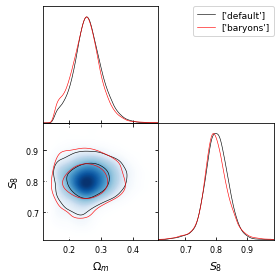

Optimization terminated successfully.
         Current function value: 0.000101
         Iterations: 21
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000431
         Iterations: 7
         Function evaluations: 14
[0.003375]
Optimization terminated successfully.
         Current function value: 0.000332
         Iterations: 7
         Function evaluations: 14
[0.0033125]
Optimization terminated successfully.
         Current function value: 0.000563
         Iterations: 21
         Function evaluations: 43
PWH_Gauss
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

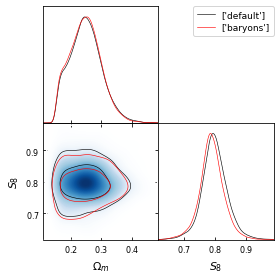

Optimization terminated successfully.
         Current function value: 0.000524
         Iterations: 21
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000674
         Iterations: 16
         Function evaluations: 32
[0.04575]
Optimization terminated successfully.
         Current function value: 0.000386
         Iterations: 15
         Function evaluations: 31
[0.040625]
Optimization terminated successfully.
         Current function value: 0.000119
         Iterations: 21
         Function evaluations: 42
3rd_moments
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

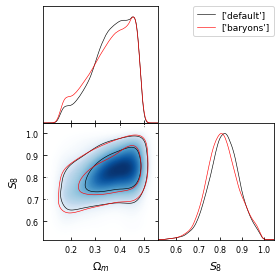

Optimization terminated successfully.
         Current function value: 0.001066
         Iterations: 25
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: 0.000743
         Iterations: 18
         Function evaluations: 36
[0.0926875]
Optimization terminated successfully.
         Current function value: 0.000743
         Iterations: 17
         Function evaluations: 34
[0.070625]
Optimization terminated successfully.
         Current function value: 0.000188
         Iterations: 25
         Function evaluations: 50
PWH_S00
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

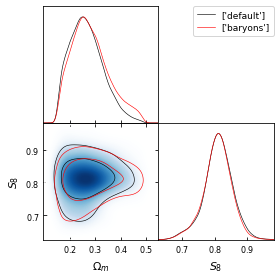

Optimization terminated successfully.
         Current function value: 0.000097
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000437
         Iterations: 6
         Function evaluations: 12
[0.00425]
Optimization terminated successfully.
         Current function value: 0.000177
         Iterations: 4
         Function evaluations: 8
[0.0046875]
Optimization terminated successfully.
         Current function value: 0.000774
         Iterations: 22
         Function evaluations: 47
PWH_S01
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

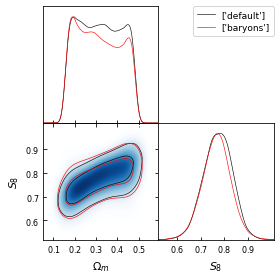

Optimization terminated successfully.
         Current function value: 0.000899
         Iterations: 22
         Function evaluations: 45
PWH_Gauss_PWH_S01_PWH_S00
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

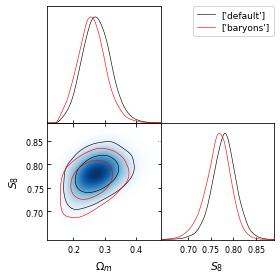

Optimization terminated successfully.
         Current function value: 0.000162
         Iterations: 22
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000136
         Iterations: 18
         Function evaluations: 36
[0.1118125]
Optimization terminated successfully.
         Current function value: 0.000097
         Iterations: 19
         Function evaluations: 38
[0.1375625]
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 18
         Function evaluations: 36
ST_S1
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

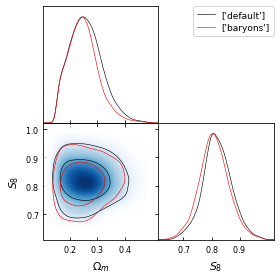

Optimization terminated successfully.
         Current function value: 0.000832
         Iterations: 22
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000567
         Iterations: 14
         Function evaluations: 29
[0.0291875]
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 14
         Function evaluations: 28
[0.0255625]
Optimization terminated successfully.
         Current function value: 0.000504
         Iterations: 21
         Function evaluations: 42
ST_S2
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

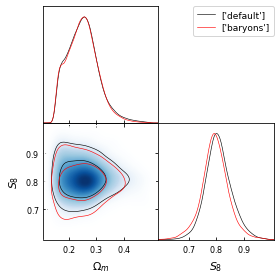

Optimization terminated successfully.
         Current function value: 0.000398
         Iterations: 19
         Function evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000119
         Iterations: 11
         Function evaluations: 22
[0.011125]
Optimization terminated successfully.
         Current function value: 0.000614
         Iterations: 9
         Function evaluations: 18
[0.00925]
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 19
         Function evaluations: 38
ST_S1_ST_S2_ST_S0
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

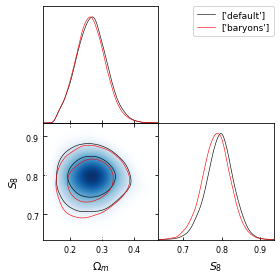

Optimization terminated successfully.
         Current function value: 0.000558
         Iterations: 18
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000451
         Iterations: 18
         Function evaluations: 38
[0.0591875]
Optimization terminated successfully.
         Current function value: 0.000795
         Iterations: 16
         Function evaluations: 32
[0.0555625]
Optimization terminated successfully.
         Current function value: 0.000351
         Iterations: 17
         Function evaluations: 34
2nd_3rd_moments
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

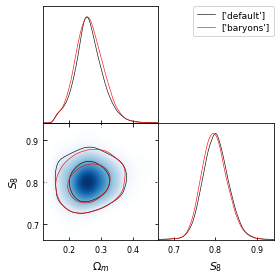

Optimization terminated successfully.
         Current function value: 0.000457
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000302
         Iterations: 12
         Function evaluations: 24
[0.016875]
Optimization terminated successfully.
         Current function value: 0.000317
         Iterations: 13
         Function evaluations: 26
[0.0201875]
Optimization terminated successfully.
         Current function value: 0.000196
         Iterations: 21
         Function evaluations: 42
2nd_moments_PWH_S01_PWH_S00
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

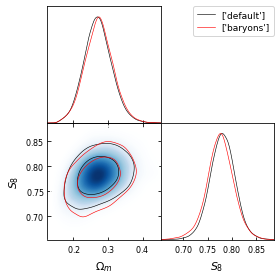

Optimization terminated successfully.
         Current function value: 0.000733
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000364
         Iterations: 13
         Function evaluations: 26
[0.0234375]
Optimization terminated successfully.
         Current function value: 0.000357
         Iterations: 13
         Function evaluations: 26
[0.02225]
Optimization terminated successfully.
         Current function value: 0.000161
         Iterations: 19
         Function evaluations: 38
all_2nd_moments_ST_PWHM_ng
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

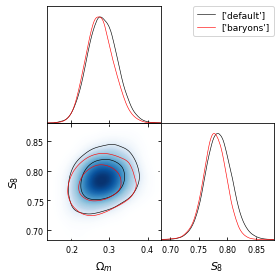

Optimization terminated successfully.
         Current function value: 0.000252
         Iterations: 20
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000167
         Iterations: 17
         Function evaluations: 34
[0.045375]
Optimization terminated successfully.
         Current function value: 0.000220
         Iterations: 17
         Function evaluations: 34
[0.047875]
Optimization terminated successfully.
         Current function value: 0.000467
         Iterations: 16
         Function evaluations: 32
all_2nd_moments_ST_PWHM_ng_3rd_moments
Removed no burn in
Removed no burn in


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 864x864 with 0 Axes>

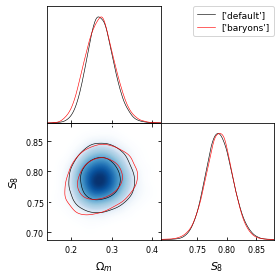

Optimization terminated successfully.
         Current function value: 0.000317
         Iterations: 14
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000217
         Iterations: 13
         Function evaluations: 27
[0.021375]
Optimization terminated successfully.
         Current function value: 0.000485
         Iterations: 12
         Function evaluations: 24
[0.01775]
Optimization terminated successfully.
         Current function value: 0.000294
         Iterations: 19
         Function evaluations: 38


<Figure size 360x600 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [35]:
import getdist
import random
import emcee as mc
from getdist import plots, MCSamples

keys = ['2nd_moments','PWH_Gauss','3rd_moments','PWH_S00','PWH_S01','PWH_Gauss_PWH_S01_PWH_S00',
'ST_S1','ST_S2','ST_S1_ST_S2_ST_S0','2nd_3rd_moments','2nd_moments_PWH_S01_PWH_S00','all_2nd_moments_ST_PWHM_ng','all_2nd_moments_ST_PWHM_ng_3rd_moments'] #all_2nd_moments_ST_PWHM_3rd_moments
#keys = ['ST_S1_ST_S2_ST_S0'] #all_2nd_moments_ST_PWHM_3rd_moments
#keys = ['3rd_moments']
cont = []
#keys = ['all_2nd_moments_ST_PWHM_3rd_moments']#
#keys = ['SR_2nd_3rd_moments'] #all_2nd_moments_ST_PWHM_3rd_moments
#cont = []
kk_ = []
for k in keys:
    #try:
        print (k)
        kk_.append(k)
        samples2 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten()],
                            names = ['$\Omega_m$','$S_8$'],
                           label=['default'],
                           # ranges={'$\Omega_m$':[0.1,0.55],
                          #          '$S_8$':[0.5,1.]},
                           settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})

        samples1 = MCSamples(samples=[results_val_4p_cosmo_B[k]['om_c'].flatten(),results_val_4p_cosmo_B[k]['S8_c'].flatten()],
                            names = ['$\Omega_m$','$S_8$',],
                           label=['baryons'],
                           # ranges={'$\Omega_m$':[0.1,0.55],
                          #          '$S_8$':[0.5,1.]},
                           settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})




#
        plt.figure(figsize=(12,12))
        g = plots.get_subplot_plotter()
    ##
        g.triangle_plot([samples2,samples1],title = k,label = ['default','baryons'] ,shaded=True)
#
        plt.show()
        try:
            xx,xxu = do_scale_cut(samples1,samples2)
            cont.append (xx[0])
        except:
            cont.append(-1)
    #except:
    #    pass

In [ ]:
keys = ['2nd_moments','PWH_Gauss','3rd_moments','PWH_S00','PWH_S01','PWH_Gauss_PWH_S01_PWH_S00',
'ST_S1','ST_S2','ST_S1_ST_S2_ST_S0','2nd_3rd_moments','2nd_moments_PWH_S01_PWH_S00','all_2nd_moments_ST_PWHM_ng','all_2nd_moments_ST_PWHM_ng_3rd_moments'] #all_2nd_moments_ST_PWHM_3rd_moments
keys

In [38]:
for i,key in enumerate(keys):
    print(key,'{0:2.2f}'.format(cont[i]))

2nd_moments 0.00
PWH_Gauss 0.05
3rd_moments 0.09
PWH_S00 0.00
PWH_S01 -1.00
PWH_Gauss_PWH_S01_PWH_S00 0.11
ST_S1 0.03
ST_S2 0.01
ST_S1_ST_S2_ST_S0 0.06
2nd_3rd_moments 0.02
2nd_moments_PWH_S01_PWH_S00 0.02
all_2nd_moments_ST_PWHM_ng 0.05
all_2nd_moments_ST_PWHM_ng_3rd_moments 0.02


# Plot chains

In [4]:
lab = 'chain_val_cosmogrid_4p/_'.format(0)
f = glob.glob('/global/cfs/cdirs/des/mgatti/LFI_runs_august_2023/everything_data/chain_val_cosmogrid_4p/*'.format(0))
i=0
results_val_4p_cosmo = read_in_chains(f,lab,recap=True)

Removed no burn in
all_2nd_moments_ST_PWHM_3rd_moments  0.006 54725 
Removed no burn in
PWH_Gauss  0.041 471 
Removed no burn in
ST_S2  0.048 370 
Removed no burn in
cl_peaks  0.034 699 
Removed no burn in
3rd_moments  0.069 196 
Removed no burn in
PWH_S00_S01  0.032 554 
Removed no burn in
2nd_PWHG  0.031 815 
Removed no burn in
2nd_3rd_moments  0.031 718 
Removed no burn in
PWH_S00  0.044 345 
Removed no burn in
2nd_moments_PWH_S01_PWH_S00  0.026 990 
Removed no burn in
all_2nd_moments_ST_PWHM_ng  0.024 1137 
Removed no burn in
PWH_Gauss_PWH_S01_PWH_S00  0.028 833 
Removed no burn in
2nd_moments_ST_S2_ST_S0_ST_S1  0.030 814 
Removed no burn in
cl  0.048 378 
Removed no burn in
ST_S1_ST_S2_ST_S0  0.036 592 
Removed no burn in
ST_S1  0.052 328 
Removed no burn in
peaks  0.047 364 
Removed no burn in
2nd_moments  0.039 575 
Removed no burn in
PWH_Gauss_ST_S2_ST_S0_ST_S1  0.032 704 
Removed no burn in
ST_S0  0.108 105 
Removed no burn in
2nd_moments_peaks  0.032 832 
Removed no burn in
P

In [120]:
results_val_4p_cosmo.keys()
keys = ['2nd_moments','PWH_Gauss','3rd_moments','PWH_S00','PWH_S01','PWH_S00_S01','ST_S1','ST_S2','ST_S1_ST_S2_ST_S0',
       '2nd_3rd_moments','2nd_moments_ST_S2_ST_S0_ST_S1','2nd_moments_PWH_S01_PWH_S00','all_2nd_moments_ST_PWHM_ng','all_2nd_moments_ST_PWHM_ng_3rd_moments']

label = ['2nd moments', 'WPHG','3rd moments','WPH S00','WPH S01+C01','WPH S00+S01+C01','ST1','ST2','ST1 + ST2',
        '2nd moments + 3rd moments',  '2nd moments + ST1 + ST2' ,  '2nd moments + WPH S00+S01+C01' ,  '2nd moments + ST1 + ST2 + WPH S00+S01+C01' ,  '2nd moments + 3rd moments + ST1 + ST2 + WPH S00+S01+C01' ]
#2nd moments & 4.1  & 4.5 & 557\\
for i,k in enumerate(keys):
    uu = copy.deepcopy(results_val_4p_cosmo[k])
    if k == '2nd_moments':
        ref = np.array([uu['S8']*100,uu['sigma_8']*100,uu['om']*100,uu['w']*10,uu['A']*10,uu['FOM']])
        print (label[i],'& {0:2.1f} &  {1:2.1f}  &  {2:2.1f}   &  {3:2.1f}  &  {4:2.1f}  &  {5:2.0f} '.format(uu['S8']*100,uu['sigma_8']*100,uu['om']*100,uu['w']*10,uu['A']*10,uu['FOM'])+"\\" + '\\')
    
    else:
        new =  np.array([uu['S8']*100,uu['sigma_8']*100,uu['om']*100,uu['w']*10,uu['A']*10,uu['FOM']])
        impr = (new-ref)/ref*100.
        impr[:-1] *= -1.
        
        impr_l = []
        for ii in impr:
            if ii >0:
                impr_l.append('({\color{OliveGreen} +'+'{0:2.0f}'.format(ii)+'\%})')
            else:
                impr_l.append('({\color{red} '+'{0:2.0f}'.format(ii)+'\%})')
        #impr_l

        #print (impr_l[0])
        print (label[i],'& {0:2.1f}'.format(uu['S8']*100) + impr_l[0] + '& {0:2.1f}'.format(uu['sigma_8']*100) + impr_l[1]+ '& {0:2.1f}'.format(uu['om']*100) + impr_l[2] + '& {0:2.1f}'.format(uu['w']*10) + impr_l[3]+ '& {0:2.1f}'.format(uu['A']*10) + impr_l[4]+ '& {0:2.0f}'.format(uu['FOM']) + impr_l[5]+"\\" + '\\')
               
               
              # {6}&  {1:2.1f}{7}&  {2:2.1f}{8}   &  {3:2.1f}{9}  &  {4:2.1f}{10}  &  {5:2.0f}{11}  \\'
             #  .format(uu['S8']*100,uu['sigma_8']*100,uu['om']*100,uu['w']*10,uu['A']*10,uu['FOM'], impr_l[0],impr_l[1],impr_l[2],impr_l[3],impr_l[4],impr_l[5]))
                                                                                                                               
    
    
   # ({\color{OliveGreen} +5\%}) & 4.8  ({\color{red} -4\%})
    
    #else:
    #    print (k,' {0:2.3f} {1:2.0f} '.format(results_val_4p_cosmo[k]['S8'],results_val_4p_cosmo[k]['FOM']))

2nd moments & 3.9 &  8.6  &  4.5   &  1.7  &  1.0  &  575 \\
WPHG & 4.1({\color{red} -6\%})& 10.5({\color{red} -22\%})& 5.1({\color{red} -15\%})& 1.8({\color{red} -5\%})& 1.0({\color{red} -3\%})& 471({\color{red} -18\%})\\
3rd moments & 6.9({\color{red} -75\%})& 9.4({\color{red} -9\%})& 8.0({\color{red} -79\%})& 1.9({\color{red} -10\%})& 1.8({\color{red} -89\%})& 196({\color{red} -66\%})\\
WPH S00 & 4.4({\color{red} -14\%})& 11.8({\color{red} -37\%})& 6.5({\color{red} -46\%})& 1.7({\color{red} -1\%})& 1.7({\color{red} -79\%})& 345({\color{red} -40\%})\\
WPH S01+C01 & 6.1({\color{red} -55\%})& 10.1({\color{red} -18\%})& 9.8({\color{red} -120\%})& 1.9({\color{red} -7\%})& 2.1({\color{red} -117\%})& 220({\color{red} -62\%})\\
WPH S00+S01+C01 & 3.2({\color{OliveGreen} +18\%})& 9.0({\color{red} -5\%})& 5.7({\color{red} -26\%})& 1.3({\color{OliveGreen} +25\%})& 1.2({\color{red} -24\%})& 554({\color{red} -4\%})\\
ST1 & 5.2({\color{red} -32\%})& 12.0({\color{red} -40\%})& 5.9({\color{red} -32\

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/ipykernel_launcher.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


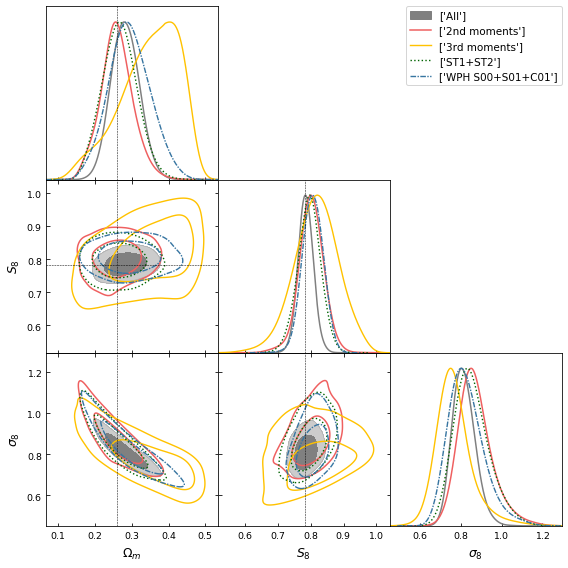

In [125]:
#SR_2nd_moments

import matplotlib.pyplot as plt
k = '2nd_moments'
#k = 'SR_2nd_moments'
target = 'cosmo DV'


samples2 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['sigma8_c'].flatten()],
                            names = ['$\Omega_m$','$S_8$','$\sigma_8$'],
                   label=['2nd moments'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})
#
k = '3rd_moments' #_ST_S2_ST_S0_ST_S1'
samples3 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten()-0.02,results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['sigma8_c'].flatten()+0.02],
                            names = ['$\Omega_m$','$S_8$','$\sigma_8$'],
                   label=['3rd moments'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})


k = 'ST_S1_ST_S2_ST_S0'
samples4 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['sigma8_c'].flatten()],
                            names = ['$\Omega_m$','$S_8$','$\sigma_8$'],
                   label=['ST1+ST2'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})

k = 'PWH_S00_S01'
samples5 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['sigma8_c'].flatten()],
                            names = ['$\Omega_m$','$S_8$','$\sigma_8$'],
                   label=['WPH S00+S01+C01'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})



'all_cl_2nd_moments_ST_PWHM_3rd_moments'
k = 'all_2nd_moments_ST_PWHM_ng'
samples6 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['sigma8_c'].flatten()],
                            names = ['$\Omega_m$','$S_8$','$\sigma_8$'],
                   label=['All'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})
#

g = plots.getSubplotPlotter(width_inch=8)

g.settings.axis_marker_color  = 'black'
#g = plots.get_subplot_plotter()
#g.triangle_plot([samples1,samples2],label = ['all','cl'],markers = [0.40,0.77,-0.7] ,shaded=True)
# [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0]
#g.triangle_plot([samples1,samples2,samples3,samples4],label = ['all','cl'],markers = [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0] ,shaded=True)
g.triangle_plot([samples6,samples2,samples3,samples4,samples5], filled=[True,False,False,False,False,False,False], colors=['grey',c_2,c_3,'#006400','#3775A1'],  alphas=[1.0,1.0,1.0,1.], contour_lws=[1.5,1.5,1.4,1.4,1.4,1.4],
                contour_ls =['-','-','-',':','-.'], contour_colors=['grey',c_2,c_3,'#006400','#3775A1'],legend_loc='upper right', markers = [0.26,0.84*np.sqrt(0.26/0.3),-1,0] ) #,
          #     param_limits = {'$\Omega_m$':[0.1,0.5],'$S_8$':[0.6,1.0],'$\sigma_8$':[0.4,1.4]})
#
#ax = g.subplots 
#ax[0][0].set_yticks([])
#ax[0][0].set_xticks([])
#
#
#
#ax[1][0].set_yticks([])
#ax[1][0].set_xticks([])
#
#ax[1][1].set_yticks([])
#ax[1][1].set_xticks([])
#
#ax[2][2].set_yticks([])
#ax[2][2].set_xticks([])
#
#ax[2][0].set_yticks([])
#ax[2][0].set_xticks([])
#
#ax[2][1].set_yticks([])
#ax[2][1].set_xticks([])
#
plt.tight_layout()

plt.savefig('//global/homes/m/mgatti/Mass_Mapping/peaks/data_extra_measurements/figures/All_sims.pdf',bbox_inches='tight')




Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


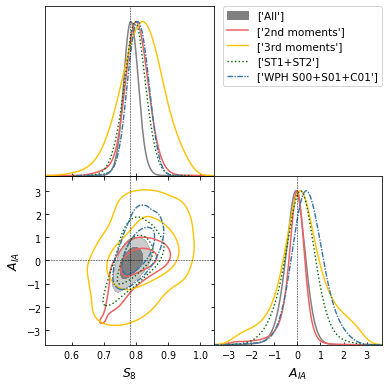

In [122]:
#SR_2nd_moments

import matplotlib.pyplot as plt
k = '2nd_moments'
#k = 'SR_2nd_moments'
target = 'cosmo DV'


samples2 = MCSamples(samples=[results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['A_c'].flatten()*6-3],
                            names = ['$S_8$','$A_{IA}$'],
                   label=['2nd moments'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})

#
k = '3rd_moments' #_ST_S2_ST_S0_ST_S1'
samples3 = MCSamples(samples=[results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['A_c'].flatten()*6-3],
                            names = ['$S_8$','$A_{IA}$'],
                   label=['3rd moments'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})



k = 'ST_S1_ST_S2_ST_S0'
samples4 = MCSamples(samples=[results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['A_c'].flatten()*6-3],
                            names = ['$S_8$','$A_{IA}$'],
                   label=['ST1+ST2'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})


k = 'PWH_S00_S01'
samples5 = MCSamples(samples=[results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['A_c'].flatten()*6-3],
                            names = ['$S_8$','$A_{IA}$'],
                   label=['WPH S00+S01+C01'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})




k = 'all_2nd_moments_ST_PWHM_ng'
samples6 = MCSamples(samples=[results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['A_c'].flatten()*6-3],
                            names = ['$S_8$','$A_{IA}$'],
                   label=['All'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})
#

g = plots.getSubplotPlotter(width_inch=5.5)
g.settings.axis_marker_color  = 'black'

#g = plots.get_subplot_plotter()
#g.triangle_plot([samples1,samples2],label = ['all','cl'],markers = [0.40,0.77,-0.7] ,shaded=True)
# [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0]
#g.triangle_plot([samples1,samples2,samples3,samples4],label = ['all','cl'],markers = [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0] ,shaded=True)
g.triangle_plot([samples6,samples2,samples3,samples4,samples5], filled=[True,False,False,False,False,False,False], colors=['grey',c_2,c_3,'#006400','#3775A1'],  alphas=[1.0,1.0,1.0,1.], contour_lws=[1.5,1.5,1.4,1.4,1.4,1.4],
                contour_ls =['-','-','-',':','-.'], contour_colors=['grey',c_2,c_3,'#006400','#3775A1'],legend_loc='upper right', markers = [0.84*np.sqrt(0.26/0.3),0] ) #
          #     param_limits = {'$\Omega_m$':[0.1,0.5],'$S_8$':[0.6,1.0],'$\sigma_8$':[0.4,1.4]})

ax = g.subplots 
#ax[0][0].set_yticks([])
#ax[0][0].set_xticks([])
#
#
#
#ax[1][0].set_yticks([])
#ax[1][0].set_xticks([])
#
#ax[1][1].set_yticks([])
#ax[1][1].set_xticks([])
#
#ax[2][2].set_yticks([])
#ax[2][2].set_xticks([])
#
#ax[2][0].set_yticks([])
#ax[2][0].set_xticks([])
#
#ax[2][1].set_yticks([])
#ax[2][1].set_xticks([])

plt.tight_layout()

plt.savefig('//global/homes/m/mgatti/Mass_Mapping/peaks/data_extra_measurements/figures/All_IA_2_sims.pdf',bbox_inches='tight')




Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no b

/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/ipykernel_launcher.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


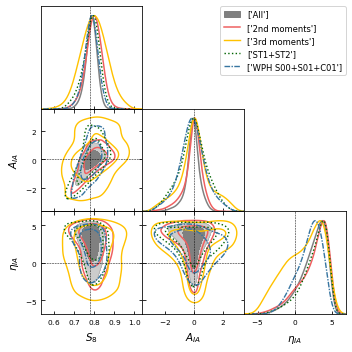

In [12]:
su = []

k = 'all_2nd_moments_ST_PWHM_ng'#,'2nd_3rd_moments']:#,'all_2nd_moments_ST_PWHM_ng']:

lab = 'chain_val_cosmogrid_4pIA/_'.format(0)
f = glob.glob('/global/cfs/cdirs/des/mgatti/LFI_runs_august_2023/everything_data/chain_val_cosmogrid_4pIA/*'.format(0))
i=0
results_val_4p_cosmo = read_in_chains(f,lab,recap=False)



lab = 'chain_val_cosmogrid_4p/_'.format(0)
f = glob.glob('/global/cfs/cdirs/des/mgatti/LFI_runs_august_2023/everything_data/chain_val_cosmogrid_4p/*'.format(0))

results_val_4p_cosmo_ref = read_in_chains(f,lab,recap=False)
#SR_2nd_moments

import matplotlib.pyplot as plt
k = '2nd_moments'
#k = 'SR_2nd_moments'
target = 'cosmo DV'


samples2 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten()*6-3,results_val_4p_cosmo[k]['w_c'].flatten()*10-5],
                            names = ['$S_8$','$A_{IA}$','$\eta_{IA}$'],
                   label=['2nd moments'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})


k = 'all_2nd_moments_ST_PWHM_ng'
samples3 = MCSamples(samples=[results_val_4p_cosmo_ref[k]['S8_c'].flatten(),results_val_4p_cosmo_ref[k]['A_c'].flatten()*6-3],
                            names = ['$S_8$','$A_{IA}$'],
                   label=['ref'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})
##
k = '3rd_moments' #_ST_S2_ST_S0_ST_S1'
samples3 =  MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten()*6-3,results_val_4p_cosmo[k]['w_c'].flatten()*10-5],
                            names = ['$S_8$','$A_{IA}$','$\eta_{IA}$'],
                   #label=['2nd moments'.format(target)],
                   label=['3rd moments'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})


k = 'ST_S1_ST_S2_ST_S0'
samples4 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten()*6-3,results_val_4p_cosmo[k]['w_c'].flatten()*10-5],
                            names = ['$S_8$','$A_{IA}$','$\eta_{IA}$'],
                  # label=['2nd moments'.format(target)],
                   label=['ST1+ST2'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})


'all_cl_2nd_moments_ST_PWHM_3rd_moments'
k = 'all_2nd_moments_ST_PWHM_ng'
samples6 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten()*6-3,results_val_4p_cosmo[k]['w_c'].flatten()*10-5],
                            names = ['$S_8$','$A_{IA}$','$\eta_{IA}$'],
                  # label=['2nd moments'.format(target)],
                   label=['All'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})
#


k = 'PWH_S00_S01'
samples5 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten()*6-3,results_val_4p_cosmo[k]['w_c'].flatten()*10-5],
                            names = ['$S_8$','$A_{IA}$','$\eta_{IA}$'],
                   
                   label=['WPH S00+S01+C01'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})

#

g = plots.getSubplotPlotter(width_inch=5)

g.settings.axis_marker_color = 'black'
#g = plots.get_subplot_plotter()
#g.triangle_plot([samples1,samples2],label = ['all','cl'],markers = [0.40,0.77,-0.7] ,shaded=True)
# [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0]
#g.triangle_plot([samples1,samples2,samples3,samples4],label = ['all','cl'],markers = [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0] ,shaded=True)
g.triangle_plot([samples6,samples2,samples3,samples4,samples5], filled=[True,False,False,False,False,False,False], colors=['grey',c_2,c_3,'#006400','#3775A1'],  alphas=[1.0,1.0,1.0,1.], contour_lws=[1.5,1.5,1.4,1.4,1.4,1.4],
                contour_ls =['-','-','-',':','-.'], contour_colors=['grey',c_2,c_3,'#006400','#3775A1'],legend_loc='upper right',markers = [0.84*np.sqrt(0.26/0.3),0.,0.,0.],axis_marker_color = 'black',axis_marker_ls=2)
          #     param_limits = {'$\Omega_m$':[0.1,0.5],'$S_8$':[0.6,1.0],'$\sigma_8$':[0.4,1.4]})

#g.triangle_plot([samples2,samples3], filled=[True,False,False,False,False,False,False], colors=['grey',c_2,c_3,'#006400','#3775A1'],  alphas=[1.0,1.0,1.0,1.], contour_lws=[1.5,1.5,1.4,1.4,1.4,1.4],
#                contour_ls =['-','-','-',':','-.'], contour_colors=['grey',c_2,c_3,'#006400','#3775A1'],legend_loc='upper right',markers = [0.84*np.sqrt(0.26/0.3),0.,0.,0.],axis_marker_color = 'black',axis_marker_ls=2)
          #     param_limits = {'$\Omega_m$':[0.1,0.5],'$S_8$':[0.6,1.0],'$\sigma_8$':[0.4,1.4]})

#ax = g.subplots 
#ax[0][0].set_yticks([])
#ax[0][0].set_xticks([])
#
#
#
#ax[1][0].set_yticks([])
#ax[1][0].set_xticks([])
#
#ax[1][1].set_yticks([])
#ax[1][1].set_xticks([])
#
#ax[2][2].set_yticks([])
#ax[2][2].set_xticks([])
#
#ax[2][0].set_yticks([])
#ax[2][0].set_xticks([])
#
#ax[2][1].set_yticks([])
#ax[2][1].set_xticks([])
#
plt.tight_layout()

#plt.savefig('//global/homes/m/mgatti/Mass_Mapping/peaks/data_extra_measurements/figures/All_sims.pdf',bbox_inches='tight')




In [ ]:
1

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


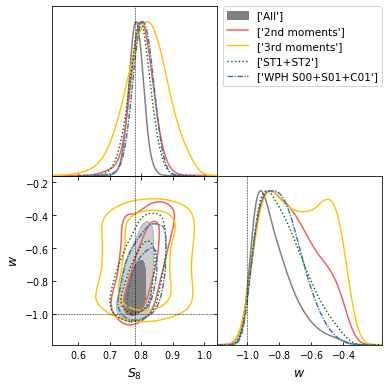

In [124]:
#SR_2nd_moments

import matplotlib.pyplot as plt
k = '2nd_moments'
#k = 'SR_2nd_moments'
target = 'cosmo DV'


samples2 = MCSamples(samples=[results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['w_c'].flatten()-1.2],
                            names = ['$S_8$','$w$'],
                   label=['2nd moments'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})

#
k = '3rd_moments' #_ST_S2_ST_S0_ST_S1'
samples3 = MCSamples(samples=[results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['w_c'].flatten()-1.2],
                            names = ['$S_8$','$w$'],
                   label=['3rd moments'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})



k = 'ST_S1_ST_S2_ST_S0'
samples4 = MCSamples(samples=[results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['w_c'].flatten()-1.2],
                            names = ['$S_8$','$w$'],
                   label=['ST1+ST2'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})


k = 'PWH_S00_S01'
samples5 = MCSamples(samples=[results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['w_c'].flatten()-1.2],
                            names = ['$S_8$','$w$'],
                   label=['WPH S00+S01+C01'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})




k = 'all_2nd_moments_ST_PWHM_ng'
samples6 = MCSamples(samples=[results_val_4p_cosmo[k]['S8_c'].flatten(),results_val_4p_cosmo[k]['w_c'].flatten()-1.2],
                            names = ['$S_8$','$w$'],
                   label=['All'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})
#

g = plots.getSubplotPlotter(width_inch=5.5)
g.settings.axis_marker_color  = 'black'

#g = plots.get_subplot_plotter()
#g.triangle_plot([samples1,samples2],label = ['all','cl'],markers = [0.40,0.77,-0.7] ,shaded=True)
# [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0]
#g.triangle_plot([samples1,samples2,samples3,samples4],label = ['all','cl'],markers = [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0] ,shaded=True)
g.triangle_plot([samples6,samples2,samples3,samples4,samples5], filled=[True,False,False,False,False,False,False], colors=['grey',c_2,c_3,'#006400','#3775A1'],  alphas=[1.0,1.0,1.0,1.], contour_lws=[1.5,1.5,1.4,1.4,1.4,1.4],
                contour_ls =['-','-','-',':','-.'], contour_colors=['grey',c_2,c_3,'#006400','#3775A1'],legend_loc='upper right', markers = [0.84*np.sqrt(0.26/0.3),-1] ) #
          #     param_limits = {'$\Omega_m$':[0.1,0.5],'$S_8$':[0.6,1.0],'$\sigma_8$':[0.4,1.4]})



plt.tight_layout()

plt.savefig('//global/homes/m/mgatti/Mass_Mapping/peaks/data_extra_measurements/figures/All_w_2_sims.pdf',bbox_inches='tight')




Removed no burn in
Removed no burn in
Removed no burn in


/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


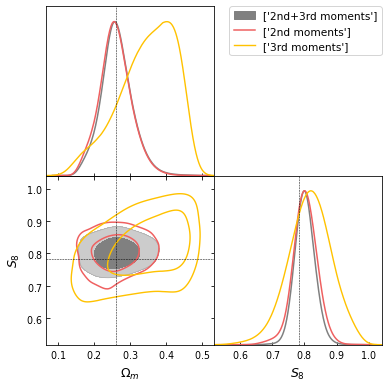

In [160]:
#SR_2nd_moments

import matplotlib.pyplot as plt
k = '2nd_3rd_moments'
#k = 'SR_2nd_moments'
target = 'cosmo DV'


samples2 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten()],
                           names = ['$\Omega_m$','$S_8$'],
                   label=['2nd+3rd moments'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})

#
k = '2nd_moments' #_ST_S2_ST_S0_ST_S1'
samples3 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten()],
                           names = ['$\Omega_m$','$S_8$'],
                   label=['2nd moments'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})

#


k = '3rd_moments'
samples4 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten()-0.02,results_val_4p_cosmo[k]['S8_c'].flatten()],
                           names = ['$\Omega_m$','$S_8$'],
                   label=['3rd moments'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})

#



g = plots.getSubplotPlotter(width_inch=5.5)
g.settings.axis_marker_color  = 'black'

#g = plots.get_subplot_plotter()
#g.triangle_plot([samples1,samples2],label = ['all','cl'],markers = [0.40,0.77,-0.7] ,shaded=True)
# [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0]
#g.triangle_plot([samples1,samples2,samples3,samples4],label = ['all','cl'],markers = [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0] ,shaded=True)
g.triangle_plot([samples2,samples3,samples4], filled=[True,False,False,False,False,False,False], colors=['grey',c_2,c_3,'#006400','#3775A1'],  alphas=[1.0,1.0,1.0,1.], contour_lws=[1.5,1.5,1.4,1.4,1.4,1.4],
                contour_ls =['-','-','-',':','-.'], contour_colors=['grey',c_2,c_3,'#006400','#3775A1'],legend_loc='upper right', markers = [0.26,0.84*np.sqrt(0.26/0.3),0] ) #
          #     param_limits = {'$\Omega_m$':[0.1,0.5],'$S_8$':[0.6,1.0],'$\sigma_8$':[0.4,1.4]})

ax = g.subplots 
#ax[0][0].set_yticks([])
#ax[0][0].set_xticks([])
#
#
#
#ax[1][0].set_yticks([])
#ax[1][0].set_xticks([])
#
#ax[1][1].set_yticks([])
#ax[1][1].set_xticks([])
#
#ax[2][2].set_yticks([])
#ax[2][2].set_xticks([])
#
#ax[2][0].set_yticks([])
#ax[2][0].set_xticks([])
#
#ax[2][1].set_yticks([])
#ax[2][1].set_xticks([])

plt.tight_layout()

plt.savefig('//global/homes/m/mgatti/Mass_Mapping/peaks/data_extra_measurements/figures/23_sims.pdf',bbox_inches='tight')




Removed no burn in
Removed no burn in
Removed no burn in


/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


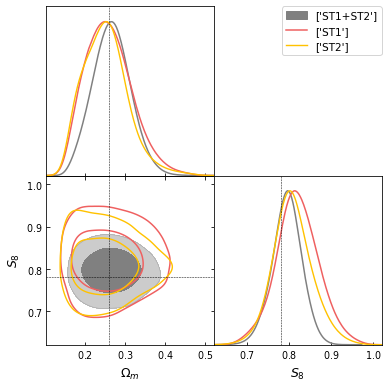

In [163]:
#SR_2nd_moments

import matplotlib.pyplot as plt
k = 'ST_S1_ST_S2_ST_S0'
#k = 'SR_2nd_moments'
target = 'cosmo DV'


samples2 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten()],
                           names = ['$\Omega_m$','$S_8$'],
                   label=['ST1+ST2'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})

#
k = 'ST_S1' #_ST_S2_ST_S0_ST_S1'
samples3 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten()],
                           names = ['$\Omega_m$','$S_8$'],
                   label=['ST1'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})

#


k = 'ST_S2'
samples4 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'].flatten(),results_val_4p_cosmo[k]['S8_c'].flatten()],
                           names = ['$\Omega_m$','$S_8$'],
                   label=['ST2'.format(target)],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})

#



g = plots.getSubplotPlotter(width_inch=5.5)
g.settings.axis_marker_color  = 'black'

#g = plots.get_subplot_plotter()
#g.triangle_plot([samples1,samples2],label = ['all','cl'],markers = [0.40,0.77,-0.7] ,shaded=True)
# [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0]
#g.triangle_plot([samples1,samples2,samples3,samples4],label = ['all','cl'],markers = [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0] ,shaded=True)
g.triangle_plot([samples2,samples3,samples4], filled=[True,False,False,False,False,False,False], colors=['grey',c_2,c_3,'#006400','#3775A1'],  alphas=[1.0,1.0,1.0,1.], contour_lws=[1.5,1.5,1.4,1.4,1.4,1.4],
                contour_ls =['-','-','-',':','-.'], contour_colors=['grey',c_2,c_3,'#006400','#3775A1'],legend_loc='upper right', markers = [0.26,0.84*np.sqrt(0.26/0.3),0] ) #
          #     param_limits = {'$\Omega_m$':[0.1,0.5],'$S_8$':[0.6,1.0],'$\sigma_8$':[0.4,1.4]})

ax = g.subplots 
#ax[0][0].set_yticks([])
#ax[0][0].set_xticks([])
#
#
#
#ax[1][0].set_yticks([])
#ax[1][0].set_xticks([])
#
#ax[1][1].set_yticks([])
#ax[1][1].set_xticks([])
#
#ax[2][2].set_yticks([])
#ax[2][2].set_xticks([])
#
#ax[2][0].set_yticks([])
#ax[2][0].set_xticks([])
#
#ax[2][1].set_yticks([])
#ax[2][1].set_xticks([])

plt.tight_layout()

plt.savefig('//global/homes/m/mgatti/Mass_Mapping/peaks/data_extra_measurements/figures/ST_sims.pdf',bbox_inches='tight')




In [57]:

%matplotlib inline
import matplotlib.pyplot as plt

su = []
for k in ['2nd_moments','all_2nd_moments_ST_PWHM_ng']:
    
  

    samples2 = MCSamples(samples=[results_val_4p[k]['om_c'.format(i)].flatten(),results_val_4p[k]['S8_c'.format(i)].flatten()],
                                     names = ['$\Omega_m$','$S_8$'],
                           label=[k],
                           # ranges={'$\Omega_m$':[0.1,0.55],
                          #          '$S_8$':[0.5,1.]},
                           settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})
    su.append(samples2)
    
    
    
g = plots.getSubplotPlotter(width_inch=5)#5.5)

g.triangle_plot(su,filled=[False,False,False,False,False,False,False],label = ['all','cl'],
                        contour_lws=[1.3,1.5,1.3,1,1,1],legend_loc='upper right', markers = [0.315,0.80*np.sqrt(0.315/0.3),-0.61,0] ) #,shaded=True)
plt.show()


NameError: name 'results_val_4p' is not defined

Removed no burn in
Removed no burn in


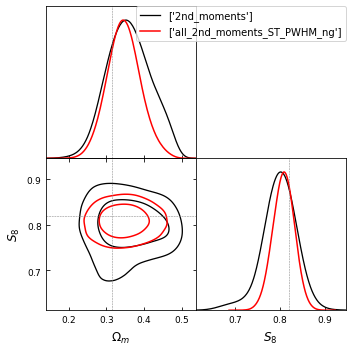

In [58]:

%matplotlib inline
import matplotlib.pyplot as plt

su = []
for k in ['2nd_moments','all_2nd_moments_ST_PWHM_ng']:
    
  

    samples2 = MCSamples(samples=[results_val_4p_cosmo[k]['om_c'.format(i)].flatten(),results_val_4p_cosmo[k]['S8_c'.format(i)].flatten()],
                                     names = ['$\Omega_m$','$S_8$'],
                           label=[k],
                           # ranges={'$\Omega_m$':[0.1,0.55],
                          #          '$S_8$':[0.5,1.]},
                           settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})
    su.append(samples2)
    
    
    
g = plots.getSubplotPlotter(width_inch=5)#5.5)

g.triangle_plot(su,filled=[False,False,False,False,False,False,False],label = ['all','cl'],
                        contour_lws=[1.3,1.5,1.3,1,1,1],legend_loc='upper right', markers = [0.315,0.80*np.sqrt(0.315/0.3),-0.61,0] ) #,shaded=True)
plt.show()


In [58]:
target = 0

In [ ]:

#chain_1x2pt_wcdm_022421_covupdate.v2.txt
#chain_3x2pt_wcdm_022421_covupdate.v2.txt



uu = np.genfromtxt('/global/cfs/cdirs/des/www/y3_chains/3x2pt/final_paper_chains/chain_3x2pt_wcdm_022421_covupdate.v2.txt', names = True)

mask = uu['COSMOLOGICAL_PARAMETERSSIGMA_8'] ==  uu['COSMOLOGICAL_PARAMETERSSIGMA_8']
mask = uu['cosmological_parametersw']>-1
sss = MCSamples(samples=np.c_[uu['cosmological_parametersomega_m'][mask],
                                      uu['COSMOLOGICAL_PARAMETERSSIGMA_8'][mask]*np.sqrt(uu['cosmological_parametersomega_m'][mask]/0.3)],
                                      weights=(uu['weight'][mask]), names = ['$\Omega_m$','$S_8$'],label=['3x2 wcdm'.format(target)])

uu = np.genfromtxt('/global/cfs/cdirs/des/www/y3_chains/3x2pt/final_paper_chains/chain_3x2pt_wcdm_022421_covupdate.v2.txt', names = True)
uu = np.genfromtxt('/global/cfs/cdirs/des/www/y3_chains/3x2pt/final_paper_chains/chain_1x2pt_wcdm_022421_covupdate.v2.txt', names = True)
uu = np.genfromtxt('/global/cfs/cdirs/des/mgatti/cosmic_shear_wcdm.txt', names = True)


  
mask =uu['cosmological_parametersw'] == uu['cosmological_parametersw'] #(uu['cosmological_parametersw']>-1) & (uu['intrinsic_alignment_parametersa2']**2<0.2)  & (uu['intrinsic_alignment_parametersalpha2']**2<1)
sss1 = MCSamples(samples=np.c_[uu['cosmological_parametersomega_m'][mask],
                                      uu['COSMOLOGICAL_PARAMETERSSIGMA_8'][mask]*np.sqrt(uu['cosmological_parametersomega_m'][mask]/0.3)],
                                      weights=(uu['weight'][mask]), names = ['$\Omega_m$','$S_8$'],
                 label=['cosmic shear wcdm'.format(target)])

    

import matplotlib.pyplot as plt
#k = 'all_2nd_moments_ST_PWHM_ng_3rd_moments'
##k = '2nd_moments'
#target = 'cosmo DV'
#
#
#samples2 = MCSamples(samples=[results1[k]['om_c'].flatten(),results1[k]['S8_c'].flatten()],
#                            names = ['$\Omega_m$','$S_8$'],
#                   label=['2nd moments'.format(target)],
#                   # ranges={'$\Omega_m$':[0.1,0.55],
#                  #          '$S_8$':[0.5,1.]},
#                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.4})


g = plots.getSubplotPlotter(width_inch=5)

#g.set_xticks([])
#g.set_yticks([])
#g = plots.get_subplot_plotter()
#g.triangle_plot([samples1,samples2],label = ['all','cl'],markers = [0.40,0.77,-0.7] ,shaded=True)
# [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0]
#g.triangle_plot([samples1,samples2,samples3,samples4],label = ['all','cl'],markers = [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0] ,shaded=True)

g.triangle_plot([samples2,sss,sss1],filled=[False,False,False,False,False,False,False],label = ['all','cl'],
                contour_lws=[1.3,1.5,1.3,1,1,1],contour_colors=['blue','red','black','#A4CD64','#3775A1'], colors=['blue','red','black','#A4CD64','#3775A1'],legend_loc='upper right')

#ax = g.subplots 
#ax[0][0].set_yticks([])
#ax[0][0].set_xticks([])
#
#ax[1][0].set_yticks([])
#ax[1][0].set_xticks([])
#
#ax[1][1].set_yticks([])
#ax[1][1].set_xticks([])

#ax[2][0].set_yticks([])
#ax[2][0].set_xticks([])

plt.tight_layout()
#plt.savefig('//global/homes/m/mgatti/Mass_Mapping/peaks/data_extra_measurements/figures/23.pdf',bbox_inches='tight')
#su = [samples2,sss,sss1]
#for kk in range(3):
#    
#    p = su[kk].getParams()
#    print (labels[kk])
#    print  ("Omega_m: {0:2.3f}+-{1:2.3f}".format( su[kk].mean(p.Om),0.5*(su[kk].twoTailLimits(p.Om, 0.68)[1]-su[kk].twoTailLimits(p.Om, 0.68)[0])))
#    print  ("S8 : {0:2.3f}+-{1:2.3f}".format( su[kk].mean(p.s8),0.5*(su[kk].twoTailLimits(p.s8, 0.68)[1]-su[kk].twoTailLimits(p.s8, 0.68)[0])))
#    
#    print ('')

/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


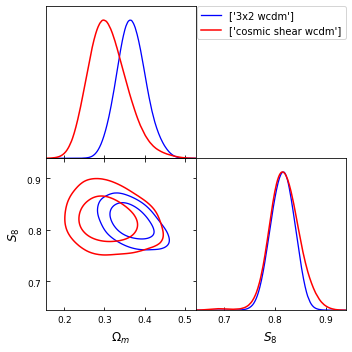

In [64]:
g = plots.getSubplotPlotter(width_inch=5)

#g.set_xticks([])
#g.set_yticks([])
#g = plots.get_subplot_plotter()
#g.triangle_plot([samples1,samples2],label = ['all','cl'],markers = [0.40,0.77,-0.7] ,shaded=True)
# [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0]
#g.triangle_plot([samples1,samples2,samples3,samples4],label = ['all','cl'],markers = [0.315,0.805*np.sqrt(0.315/0.3),-0.61,0] ,shaded=True)

g.triangle_plot([sss,sss1],filled=[False,False,False,False,False,False,False],label = ['all','cl'],
                contour_lws=[1.3,1.5,1.3,1,1,1],contour_colors=['blue','red','black','#A4CD64','#3775A1'], colors=['blue','red','black','#A4CD64','#3775A1'],legend_loc='upper right')

#ax = g.subplots 
#ax[0][0].set_yticks([])
#ax[0][0].set_xticks([])
#
#ax[1][0].set_yticks([])
#ax[1][0].set_xticks([])
#
#ax[1][1].set_yticks([])
#ax[1][1].set_xticks([])

#ax[2][0].set_yticks([])
#ax[2][0].set_xticks([])

plt.tight_layout()
#plt.savefig('//global/homes/m/mgatti/Mass_Mapping/peaks/data_extra_measurements/figures/23.pdf',bbox_inches='tight')
#su = [samples2,sss,sss1]


In [1]:
import glob
f = glob.glob('/global/cfs/cdirs/des/mgatti/Dirac/LFI_dv_cosmogrid_fiducial/peaks//*')
len(f)#*6*4

798

# plot comparison

In [14]:
#samples4 = MCSamples(samples=[sampler2d_[:,:,0].flatten(),sampler2d_[:,:,1].flatten(),sampler2d_[:,:,2].flatten()-1.2,sampler2d_[:,:,3].flatten()*6-3],
#                            names = ['Om','s8','w','A'],
#                   label=['NLA LFI'],
#                   # ranges={'$\Omega_m$':[0.1,0.55],
#                  #          '$S_8$':[0.5,1.]},
#                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})
##
import numpy as np
sampler2d_NLA2 = np.load('../sampler2d_NLA2.npy')
sampler2d_NLA = np.load('../sampler2d_NLA.npy')


#
chains_dict = dict()
chains_dict['2nd moments1'] ='/global/cfs/cdirs/des/mgatti/chain_data_NLA.txt'

labels = []
su = []

for k in chains_dict.keys():
    
    
    uu = np.genfromtxt(chains_dict[k], names = True)
    mask = uu['cosmological_parametersomega_m'] > 0.15
    ss = MCSamples(samples=np.c_[uu['cosmological_parametersomega_m'][mask],
                                      -0.03+(uu['cosmological_parameterssigma8_input']*np.sqrt(uu['cosmological_parametersomega_m']/0.3))[mask],uu['cosmological_parametersw'][mask],uu['intrinsic_alignment_parametersa1'][mask]],
                                      label=['Halofit'],
                                      weights=(uu['weight'][mask]), names = ['Om','s8','w','A'], labels = ['om','s8','w','A'])


    
    
samples4_c = MCSamples(samples=[sampler2d_NLA2[:,:,0].flatten(),-0.03+sampler2d_NLA2[:,:,1].flatten(),sampler2d_NLA2[:,:,2].flatten()-1.2,sampler2d_NLA[:,:,3].flatten()*6-3],
                            names = ['Om','s8','w','A'],labels = [r'\Omega_{\rm m}',r'S_8','ns'],
                   label=['LFI'],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})
#



samples4_c2 = MCSamples(samples=[sampler2d_NLA[:,:,0].flatten(),-0.03+sampler2d_NLA[:,:,1].flatten(),sampler2d_NLA[:,:,2].flatten()-1.2,sampler2d_NLA[:,:,3].flatten()*6-3],
                            names = ['Om','s8','w','A'],labels = [r'$\Omega_{\rm m}$',r'$S_8$','ns'],
                   label=['halofit+Gaussian likelihood'],
                   # ranges={'$\Omega_m$':[0.1,0.55],
                  #          '$S_8$':[0.5,1.]},
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})





Removed no burn in
Removed no burn in
Removed no burn in


Omega_m: 0.269+-0.068
S8 : 0.780+-0.022

Omega_m: 0.258+-0.064
S8 : 0.788+-0.022



<Figure size 288x288 with 0 Axes>

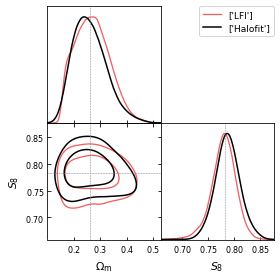

In [15]:
plt.figure(figsize=(4,4))
g = plots.get_subplot_plotter()
#g.triangle_plot([samples4_c,ss],['Om','s8'],label = ['all','cl'] ,shaded=True)

g.triangle_plot([samples4_c,ss],['Om','s8'],filled=[False,False,False,False,False,False,False],label = ['all','cl'],
                contour_lws=[1.3,1.5,1.3,1,1,1],contour_colors=[c_2,'black','#A4CD64','#3775A1'], 
                colors=[c_2,'black','#A4CD64','#3775A1'],legend_loc='upper right'  ,markers =[0.26,0.84*np.sqrt(0.26/0.3),-1,0] ) 



su = [samples4_c,ss]
for kk in range(2):
    p = su[kk].getParams()
    #print (labels[kk])
    print  ("Omega_m: {0:2.3f}+-{1:2.3f}".format( su[kk].mean(p.Om),0.5*(su[kk].twoTailLimits(p.Om, 0.68)[1]-su[kk].twoTailLimits(p.Om, 0.68)[0])))
    print  ("S8 : {0:2.3f}+-{1:2.3f}".format( su[kk].mean(p.s8),0.5*(su[kk].twoTailLimits(p.s8, 0.68)[1]-su[kk].twoTailLimits(p.s8, 0.68)[0])))
    
    print ('')
    
#plt.suptitle('test on cosmogrid DV',y=1.05)
#plt.tight_layout()
plt.savefig('/global/homes/m/mgatti/Mass_Mapping/peaks/figures/cosmosis_LFI_comparison.pdf',bbox_inches='tight')


In [11]:
0.810- 0.84*np.sqrt(0.26/0.3)

0.028002557548939322